# Imports

In [1]:
#basic data analysis
import numpy as np
import pandas as pd

#visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import itertools #heatmap of categorical without repeats

#for Chi-Square
import scipy.stats as stats

#data preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

#tree-based models
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#evaluation metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV

# Initial Look

Now let's import and take a look at the data:

In [2]:
#import the dataset
student_health = pd.read_csv("C:/Users/barbe/OneDrive/URI DS Program/577 Data Enabled Capstone/student_health_data.csv")

In [3]:
#look at first few instances
student_health.head()

Student_ID  Age Gender  Heart_Rate  Blood_Pressure_Systolic  \
0           1   24      M   50.663217               122.173015   
1           2   21      F   57.926042               110.778407   
2           3   22      M   59.294219               109.375673   
3           4   24      M   76.826232               125.142227   
4           5   20      M   68.342769               107.515592   

   Blood_Pressure_Diastolic  Stress_Level_Biosensor  Stress_Level_Self_Report  \
0                 84.419860                3.137350                  9.028669   
1                 75.696145                3.699078                  5.819697   
2                 83.803814                6.785156                  5.892360   
3                 78.091587                6.408509                  6.884001   
4                 80.674937                7.264719                  4.483450   

  Physical_Activity Sleep_Quality      Mood  Study_Hours  Project_Hours  \
0              High      Moderate     Happy    34.520973      16.800956   
1          Moderate          Good  Stressed    16.763846      15.791154   
2               Low      Moderate     Happy    44.203798      25.678437   
3              High          Poor     Happy    21.776645      20.808391   
4          Moderate          Poor     Happy     8.964999      15.194045   

  Health_Risk_Level  
0          Moderate  
1          Moderate  
2          Moderate  
3              High  
4          Moderate

From looking at the first few instances, I can see that some variables are numerical and some are categorical. It also looks like Student_ID can be removed.

In [4]:
#check for missing values
print('Check for missing values:')
print(student_health.isna().sum(), '\n')

#check for duplicates
print('Check for duplicates: \n', student_health.duplicated().sum())

Check for missing values:
Student_ID                  0
Age                         0
Gender                      0
Heart_Rate                  0
Blood_Pressure_Systolic     0
Blood_Pressure_Diastolic    0
Stress_Level_Biosensor      0
Stress_Level_Self_Report    0
Physical_Activity           0
Sleep_Quality               0
Mood                        0
Study_Hours                 0
Project_Hours               0
Health_Risk_Level           0
dtype: int64 

Check for duplicates: 
 0


No missing values and no duplicates. Let's go ahead and remove Student_ID.

In [5]:
student_health = student_health.drop(columns=["Student_ID"])

In [6]:
student_health.head()

Age Gender  Heart_Rate  Blood_Pressure_Systolic  Blood_Pressure_Diastolic  \
0   24      M   50.663217               122.173015                 84.419860   
1   21      F   57.926042               110.778407                 75.696145   
2   22      M   59.294219               109.375673                 83.803814   
3   24      M   76.826232               125.142227                 78.091587   
4   20      M   68.342769               107.515592                 80.674937   

   Stress_Level_Biosensor  Stress_Level_Self_Report Physical_Activity  \
0                3.137350                  9.028669              High   
1                3.699078                  5.819697          Moderate   
2                6.785156                  5.892360               Low   
3                6.408509                  6.884001              High   
4                7.264719                  4.483450          Moderate   

  Sleep_Quality      Mood  Study_Hours  Project_Hours Health_Risk_Level  
0      Moderate     Happy    34.520973      16.800956          Moderate  
1          Good  Stressed    16.763846      15.791154          Moderate  
2      Moderate     Happy    44.203798      25.678437          Moderate  
3          Poor     Happy    21.776645      20.808391              High  
4          Poor     Happy     8.964999      15.194045          Moderate

In [7]:
#look at shape/dimension of dataset
print(student_health.shape)
#look at data types for each column
print(student_health.dtypes)

(1000, 13)
Age                           int64
Gender                       object
Heart_Rate                  float64
Blood_Pressure_Systolic     float64
Blood_Pressure_Diastolic    float64
Stress_Level_Biosensor      float64
Stress_Level_Self_Report    float64
Physical_Activity            object
Sleep_Quality                object
Mood                         object
Study_Hours                 float64
Project_Hours               float64
Health_Risk_Level            object
dtype: object


The dataset consists of numerical variables (integer and float) and object variables. Looking through, these object variables are really just categorical variables. So let's change the datatype from object to categorical.

In [8]:
#convert object variables to categorical variables
for col in student_health.select_dtypes(include = ['object']).columns:
    student_health[col] = student_health[col].astype('category')

#check data types
print(student_health.dtypes)

Age                            int64
Gender                      category
Heart_Rate                   float64
Blood_Pressure_Systolic      float64
Blood_Pressure_Diastolic     float64
Stress_Level_Biosensor       float64
Stress_Level_Self_Report     float64
Physical_Activity           category
Sleep_Quality               category
Mood                        category
Study_Hours                  float64
Project_Hours                float64
Health_Risk_Level           category
dtype: object


Now all objects are set as category. This will help with analyzing the data.

# Outlier Detection 

The next step is outlier detection. Let's begin by looking at the summary statistics.

In [9]:
#basic stats for numerical columns
student_health.describe()

Age   Heart_Rate  Blood_Pressure_Systolic  \
count  1000.0000  1000.000000              1000.000000   
mean     20.9600    70.101863               119.835380   
std       2.0036     9.544663                14.604307   
min      18.0000    50.000000                90.000000   
25%      19.0000    63.347970               109.386868   
50%      21.0000    70.330916               120.051654   
75%      23.0000    76.425149               130.397799   
max      24.0000    99.650104               165.929204   

       Blood_Pressure_Diastolic  Stress_Level_Biosensor  \
count               1000.000000             1000.000000   
mean                  79.854756                5.483909   
std                    9.641699                2.596108   
min                   60.000000                1.008491   
25%                   73.115420                3.270567   
50%                   79.651738                5.368891   
75%                   86.535640                7.674233   
max                  107.659796                9.994153   

       Stress_Level_Self_Report  Study_Hours  Project_Hours  
count               1000.000000  1000.000000    1000.000000  
mean                   5.361601    30.227037      14.887368  
std                    2.550382    10.341060       4.888624  
min                    1.002186     5.000000       0.000000  
25%                    3.172409    23.262704      11.573503  
50%                    5.234889    30.432767      14.765873  
75%                    7.471178    37.245193      18.159167  
max                    9.964115    60.000000      32.720325

Items of note:
- We can see that some of the features are on different scales - we'll address this when preparing to model.
- There seems to be a relatively large jump from the 75th percentile value to the max value in some features, namely heart rate, blood pressure, and study/project hours. This may indicate outliers.
- The average and median heart rate and blood pressures are in line with establish norms. This suggests that the data accurately reflects the general population. 
    - https://www.heart.org/en/health-topics/high-blood-pressure/understanding-blood-pressure-readings
    - https://www.heart.org/en/health-topics/high-blood-pressure/the-facts-about-high-blood-pressure/all-about-heart-rate-pulse
- Slightly higher blood pressure and heart rate is relatively common, though the max values here indicate potentially serious health issues.

Let's investigate the spread of data more thoroughly.

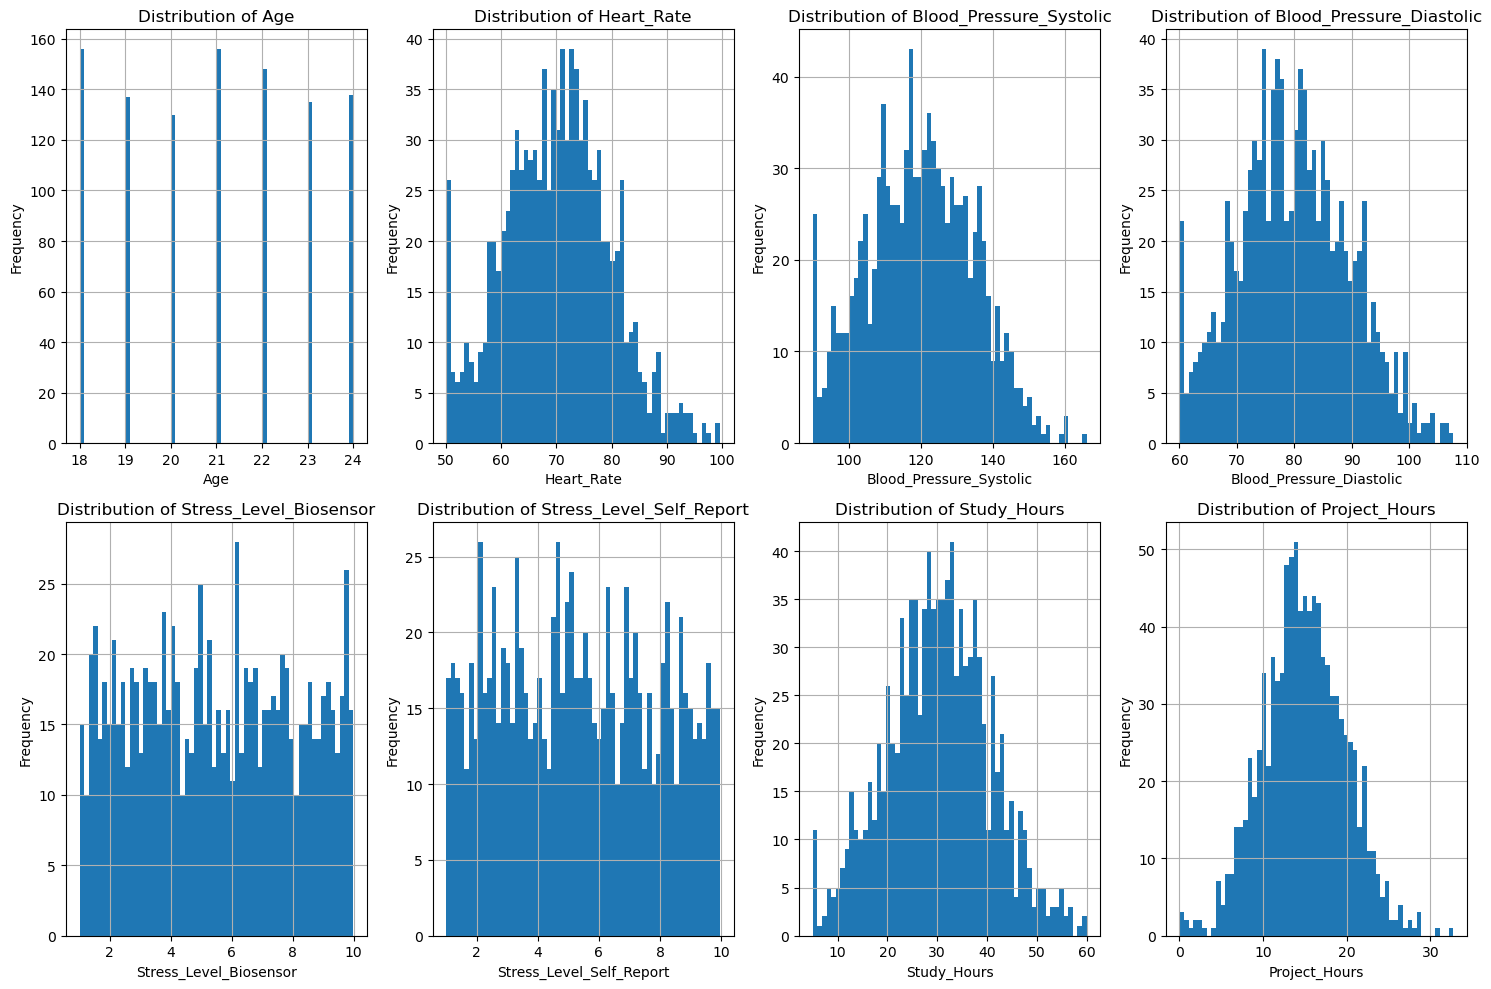

In [10]:
#list of numerical variables
numerical_var = ['Age', 'Heart_Rate', 'Blood_Pressure_Systolic', 'Blood_Pressure_Diastolic',
                 'Stress_Level_Biosensor', 'Stress_Level_Self_Report', 'Study_Hours', 'Project_Hours']

# subplots set up
rows = 2
cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(15, 10)) 
axes = axes.flatten()


#histogram
#iterate over each numerical variable

i = 0 
for var in numerical_var:
    #plot a histogram for current variable
    student_health[var].hist(bins=60, ax = axes[i])
    #set title of the plot
    axes[i].set_title(f'Distribution of {var}')
    #label x-axis with variable name
    axes[i].set_xlabel(var)
    #label y-axis
    axes[i].set_ylabel('Frequency')
    i += 1

plt.tight_layout()
plt.show()

Items of Note:
- Age distribution is relatively uniform, suggesting a consistent number of students across the age range.
- Heart rate, blood pressure, and study/project hours follow a normal distribution.
- Stress levels appear uniform, indicating that students' stress levels are fairly evenly distributed. This also indicates consistent self-reported stress levels.

The tails further suggest potential outliers. Let's use boxplots to explicitly see if there are outliers.

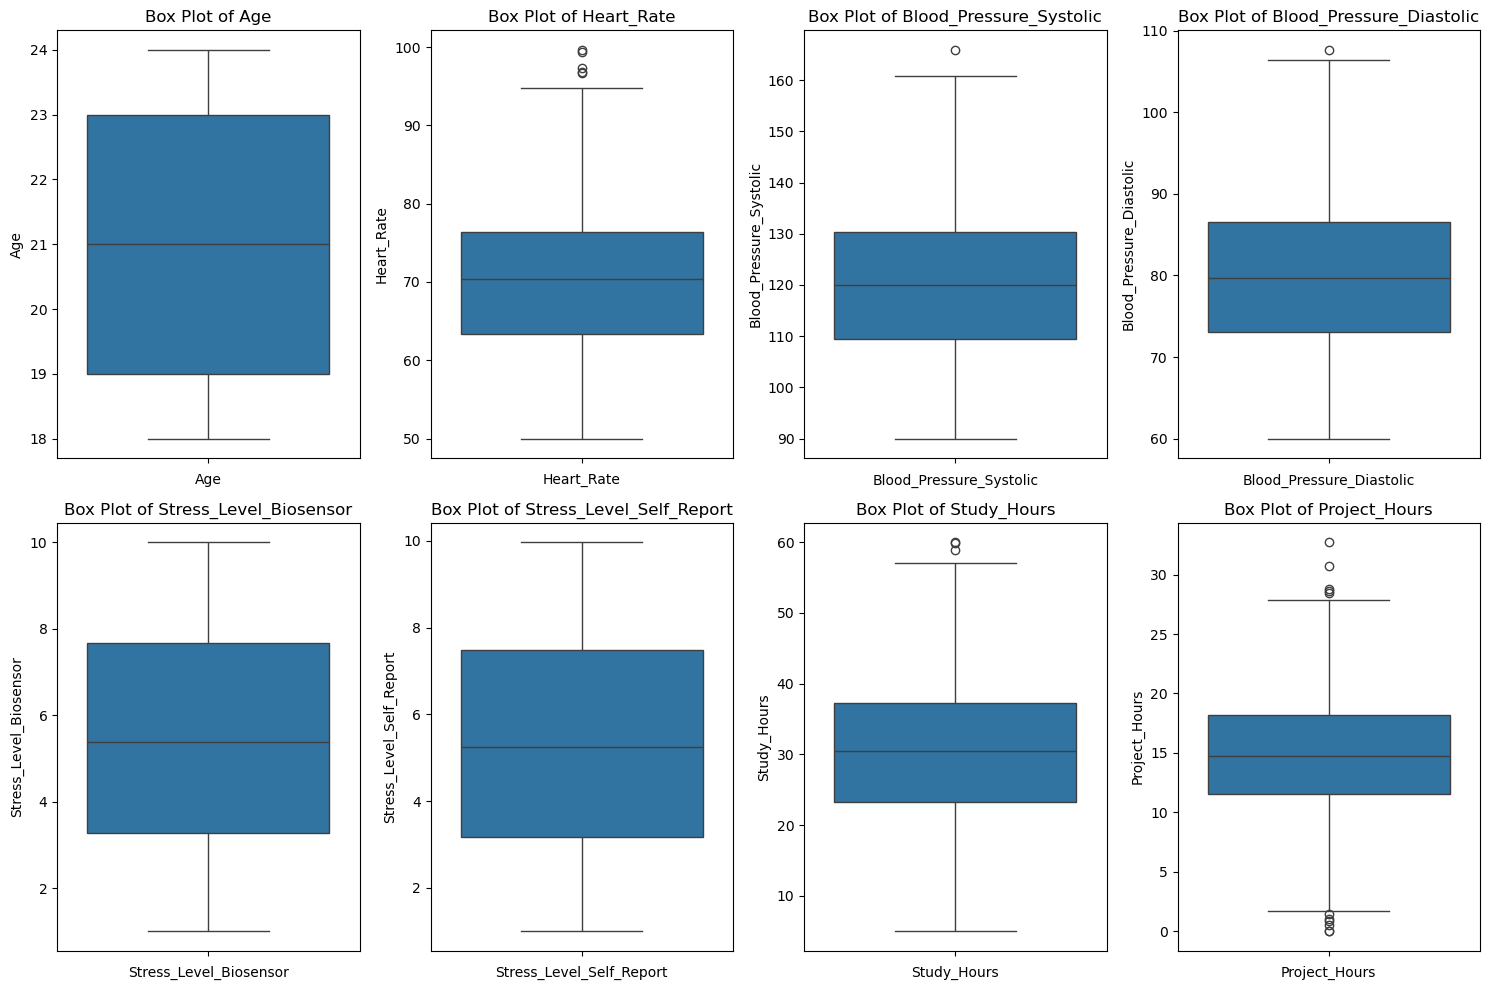

In [11]:
# subplots set up
rows = 2
cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(15, 10)) 
axes = axes.flatten()


#boxplot
#iterate through each numerical variable
i = 0
for var in numerical_var:
    #create boxplot for current variable
    sns.boxplot(y=student_health[var], ax = axes[i])
    #add title with variable name
    axes[i].set_title(f'Box Plot of {var}')
    #label x-axis with variable name
    axes[i].set_xlabel(var)
    i += 1
    
# Adjust layout
plt.tight_layout()
plt.show()

The histograms and boxplots verify outliers for Heart_Rate, Blood_Pressure_Systolic, Blood_Pressure_Diastolic, Study_Hours, and Project_Hours. It looks like Heart_Rate and Project_Hours hold the most outliers. Age, and stress levels don't have any outliers.

Using IQR, let's look at the instances with outliers.

In [12]:
#define function to identify outliers via IQR
def identify_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

#create dataframe to store outliers
outliers_df = pd.DataFrame()

#apply function to numerical variables
#iterate over variables
for var in numerical_var:
    outliers = identify_outliers(student_health, var)
    #concatenate outliers to outlier dataframe
    outliers_df = pd.concat([outliers_df, outliers])

#drop duplicate rows since some rows may be outliers in multiple columns
outliers_df = outliers_df.drop_duplicates()

#display the outliers
outliers_df

Age Gender  Heart_Rate  Blood_Pressure_Systolic  \
198   19      M   99.650104               152.812332   
275   21      M   99.377528                98.811964   
769   24      F   96.631824               142.695139   
941   22      M   96.875344               111.297845   
979   24      F   97.308672               135.537379   
899   18      F   50.000000               165.929204   
439   19      F   66.932196               135.787934   
63    18      M   74.805621               113.068560   
443   24      F   55.928560                90.000000   
837   24      M   70.058106               129.669424   
48    18      F   83.238748               116.201176   
104   23      M   57.701306               113.281283   
179   21      M   62.014547               109.356416   
203   23      M   75.642774               131.732739   
209   23      F   78.731585               120.979023   
288   24      F   79.629655               150.268619   
291   21      M   70.674985               109.148058   
498   19      M   72.832994               119.095665   
805   23      M   69.946026               113.685917   
931   19      M   63.506687               109.426973   
932   19      M   70.831225                94.051533   

     Blood_Pressure_Diastolic  Stress_Level_Biosensor  \
198                 81.798311                7.665972   
275                 74.927286                6.611548   
769                 63.073184                3.940650   
941                 69.414963                1.630618   
979                 78.658548                8.664233   
899                 77.116078                3.314371   
439                107.659796                9.342168   
63                  73.850496                9.185936   
443                 64.111815                3.508249   
837                 82.116004                2.518745   
48                  73.491673                7.641350   
104                 88.247490                2.853820   
179                 84.616663                2.671993   
203                 91.438367                6.527676   
209                 77.112047                8.537253   
288                 83.443842                1.363005   
291                 83.409527                2.331625   
498                 60.000000                4.122631   
805                 87.172836                7.409982   
931                 66.742062                4.404840   
932                 73.409932                1.795573   

     Stress_Level_Self_Report Physical_Activity Sleep_Quality      Mood  \
198                  4.733622          Moderate      Moderate   Neutral   
275                  3.888419          Moderate      Moderate   Neutral   
769                  3.479020          Moderate      Moderate     Happy   
941                  6.891591          Moderate      Moderate  Stressed   
979                  1.260971              High          Good     Happy   
899                  6.006128          Moderate      Moderate     Happy   
439                  1.262536          Moderate      Moderate   Neutral   
63                   5.587814          Moderate      Moderate     Happy   
443                  8.802469          Moderate          Poor  Stressed   
837                  8.253731               Low          Poor     Happy   
48                   7.408648              High          Poor     Happy   
104                  7.817221               Low          Good   Neutral   
179                  9.642397          Moderate          Good     Happy   
203                  6.485757          Moderate          Good   Neutral   
209                  2.924211          Moderate      Moderate     Happy   
288                  2.139903          Moderate      Moderate   Neutral   
291                  4.386806               Low          Good  Stressed   
498                  4.933304          Moderate          Good     Happy   
805                  5.803529          Moderate          Poor   Neutral   
931              

In [13]:
#look at shape/dimension of dataset
outliers_df.shape

(21, 13)

Here is what I see looking at the outliers:
- Heart_Rate has 5 outliers, though it should be noted that they fall within the higher average heart rate (60-100). Stress levels, physical activities, and sleep quality can impact heart rate. High heart rates could be correlated to high stress, though this isn't always the case as we see in the 3rd instance. While most are labeled as moderate, it's crucial to consider if other factors contribute to this rating.
- Blood_Pressure_Systolic has 1 outlier. This is much higher than the norm, indicating potential hypertension. While marked as moderate health risk, considering the high blood pressure, other factors like stress level and physical activity could play a role.
- Blood_Pressure_Diastolic also has 1 outlier, which is significantly high. Similar to systolic, other lifestyle factors may contribute the the risk level.
- Stress levels don't seem to hold any outliers.
- Study_Hours have 3 outliers. These students study much longer compared to other students. Poor sleep quality and varying moods indicate that excessive study hours could negatively impact their well-being. The risk level is moderate, suggesting that while these students manage stress, the high study hours could eventually lead to burnout or other issues.
- Project_Hours have 11 outliers. We see that some students spend a lot of hours on projects and others don't spend much time at all. While most instances are labeled as moderate, one is marked as high. This indicates that high project hours could correlate with increased health risks, especially when paired with other factors like sleep quality and stress levels.

Only 21 instance were considered to have outliers. Realistically, we can remove these and still have plenty of data to work with since the original dataset contains 1000 instances. With that in mind, let's go ahead and remove the instances with outliers.

In [14]:
#get outlier indices
outlier_indices = outliers_df.index

#drop rows in dataset with outlier indices
cleaned_df = student_health.drop(outlier_indices)

#look at dimension of dataset
print(cleaned_df.shape)

(979, 13)


In [15]:
#look at basic stats
cleaned_df.describe()

Age  Heart_Rate  Blood_Pressure_Systolic  \
count  979.000000  979.000000               979.000000   
mean    20.954035   69.979106               119.788093   
std      1.997169    9.367907                14.482425   
min     18.000000   50.000000                90.000000   
25%     19.000000   63.307344               109.383136   
50%     21.000000   70.304789               120.061395   
75%     23.000000   76.343322               130.365350   
max     24.000000   94.722795               160.739199   

       Blood_Pressure_Diastolic  Stress_Level_Biosensor  \
count                979.000000              979.000000   
mean                  79.890649                5.493225   
std                    9.615105                2.593141   
min                   60.000000                1.008491   
25%                   73.103106                3.294550   
50%                   79.726681                5.401436   
75%                   86.548586                7.674901   
max                  106.450368                9.994153   

       Stress_Level_Self_Report  Study_Hours  Project_Hours  
count                979.000000   979.000000     979.000000  
mean                   5.356630    30.077246      14.885170  
std                    2.552939    10.265443       4.660111  
min                    1.002186     5.000000       1.729188  
25%                    3.152128    23.172107      11.646913  
50%                    5.232666    30.314270      14.768098  
75%                    7.474922    37.189126      18.106878  
max                    9.964115    57.136198      27.885272

Looks like we successfully removed all outliers!

# Correlation

### Numerical

We'll begin by looking at correlations between numerical variables.

In [16]:
#calculate Pearson Correlation Matrix
pearson_corr = cleaned_df[numerical_var].corr(method='pearson')
pearson_corr

Age  Heart_Rate  Blood_Pressure_Systolic  \
Age                       1.000000    0.014115                -0.008258   
Heart_Rate                0.014115    1.000000                 0.002642   
Blood_Pressure_Systolic  -0.008258    0.002642                 1.000000   
Blood_Pressure_Diastolic  0.008855   -0.021330                 0.015759   
Stress_Level_Biosensor    0.043984    0.039858                -0.033959   
Stress_Level_Self_Report  0.016734   -0.017568                -0.011818   
Study_Hours              -0.078618    0.041596                -0.004928   
Project_Hours            -0.000572   -0.000839                -0.048204   

                          Blood_Pressure_Diastolic  Stress_Level_Biosensor  \
Age                                       0.008855                0.043984   
Heart_Rate                               -0.021330                0.039858   
Blood_Pressure_Systolic                   0.015759               -0.033959   
Blood_Pressure_Diastolic                  1.000000               -0.011212   
Stress_Level_Biosensor                   -0.011212                1.000000   
Stress_Level_Self_Report                 -0.008532               -0.016057   
Study_Hours                               0.001248               -0.028816   
Project_Hours                            -0.012685                0.001118   

                          Stress_Level_Self_Report  Study_Hours  Project_Hours  
Age                                       0.016734    -0.078618      -0.000572  
Heart_Rate                               -0.017568     0.041596      -0.000839  
Blood_Pressure_Systolic                  -0.011818    -0.004928      -0.048204  
Blood_Pressure_Diastolic                 -0.008532     0.001248      -0.012685  
Stress_Level_Biosensor                   -0.016057    -0.028816       0.001118  
Stress_Level_Self_Report                  1.000000    -0.010993       0.016558  
Study_Hours                              -0.010993     1.000000      -0.036473  
Project_Hours                             0.016558    -0.036473       1.000000

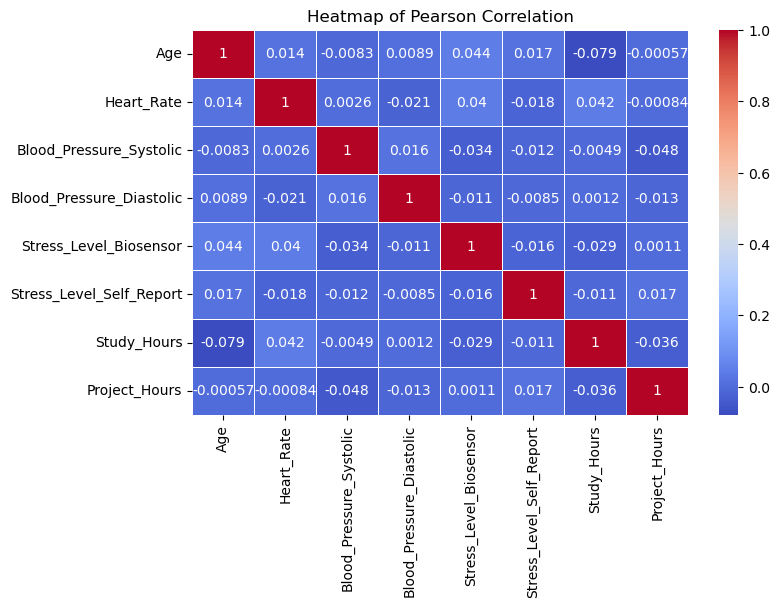

In [17]:
#heatmap of Pearson correlation matrix
plt.figure(figsize=(8, 5))
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of Pearson Correlation')
plt.show()

Pearson correlation shows no that no numerical features are correlated. With that said, Pearson Correlation can't capture nonlinear relationships. We'll further analyze numerical correlation with Spearman's Rank Correlation.

In [18]:
#calculate Spearman's Rank Correlation Matric
spearman_corr = cleaned_df[numerical_var].corr(method='spearman')
spearman_corr

Age  Heart_Rate  Blood_Pressure_Systolic  \
Age                       1.000000    0.010718                -0.004715   
Heart_Rate                0.010718    1.000000                 0.010531   
Blood_Pressure_Systolic  -0.004715    0.010531                 1.000000   
Blood_Pressure_Diastolic  0.001238   -0.008705                 0.013235   
Stress_Level_Biosensor    0.044051    0.052829                -0.034453   
Stress_Level_Self_Report  0.015880   -0.022482                -0.010599   
Study_Hours              -0.079549    0.036688                -0.006829   
Project_Hours             0.004606    0.000002                -0.037278   

                          Blood_Pressure_Diastolic  Stress_Level_Biosensor  \
Age                                       0.001238                0.044051   
Heart_Rate                               -0.008705                0.052829   
Blood_Pressure_Systolic                   0.013235               -0.034453   
Blood_Pressure_Diastolic                  1.000000               -0.017856   
Stress_Level_Biosensor                   -0.017856                1.000000   
Stress_Level_Self_Report                 -0.000378               -0.016621   
Study_Hours                               0.001954               -0.031668   
Project_Hours                            -0.022251               -0.001035   

                          Stress_Level_Self_Report  Study_Hours  Project_Hours  
Age                                       0.015880    -0.079549       0.004606  
Heart_Rate                               -0.022482     0.036688       0.000002  
Blood_Pressure_Systolic                  -0.010599    -0.006829      -0.037278  
Blood_Pressure_Diastolic                 -0.000378     0.001954      -0.022251  
Stress_Level_Biosensor                   -0.016621    -0.031668      -0.001035  
Stress_Level_Self_Report                  1.000000    -0.010669       0.013275  
Study_Hours                              -0.010669     1.000000      -0.039752  
Project_Hours                             0.013275    -0.039752       1.000000

Again, we find that no numerical features are correlated. To ensure a thorough investigation, let's visualize correlations by viewing scatterplots for every pair of numerical features.

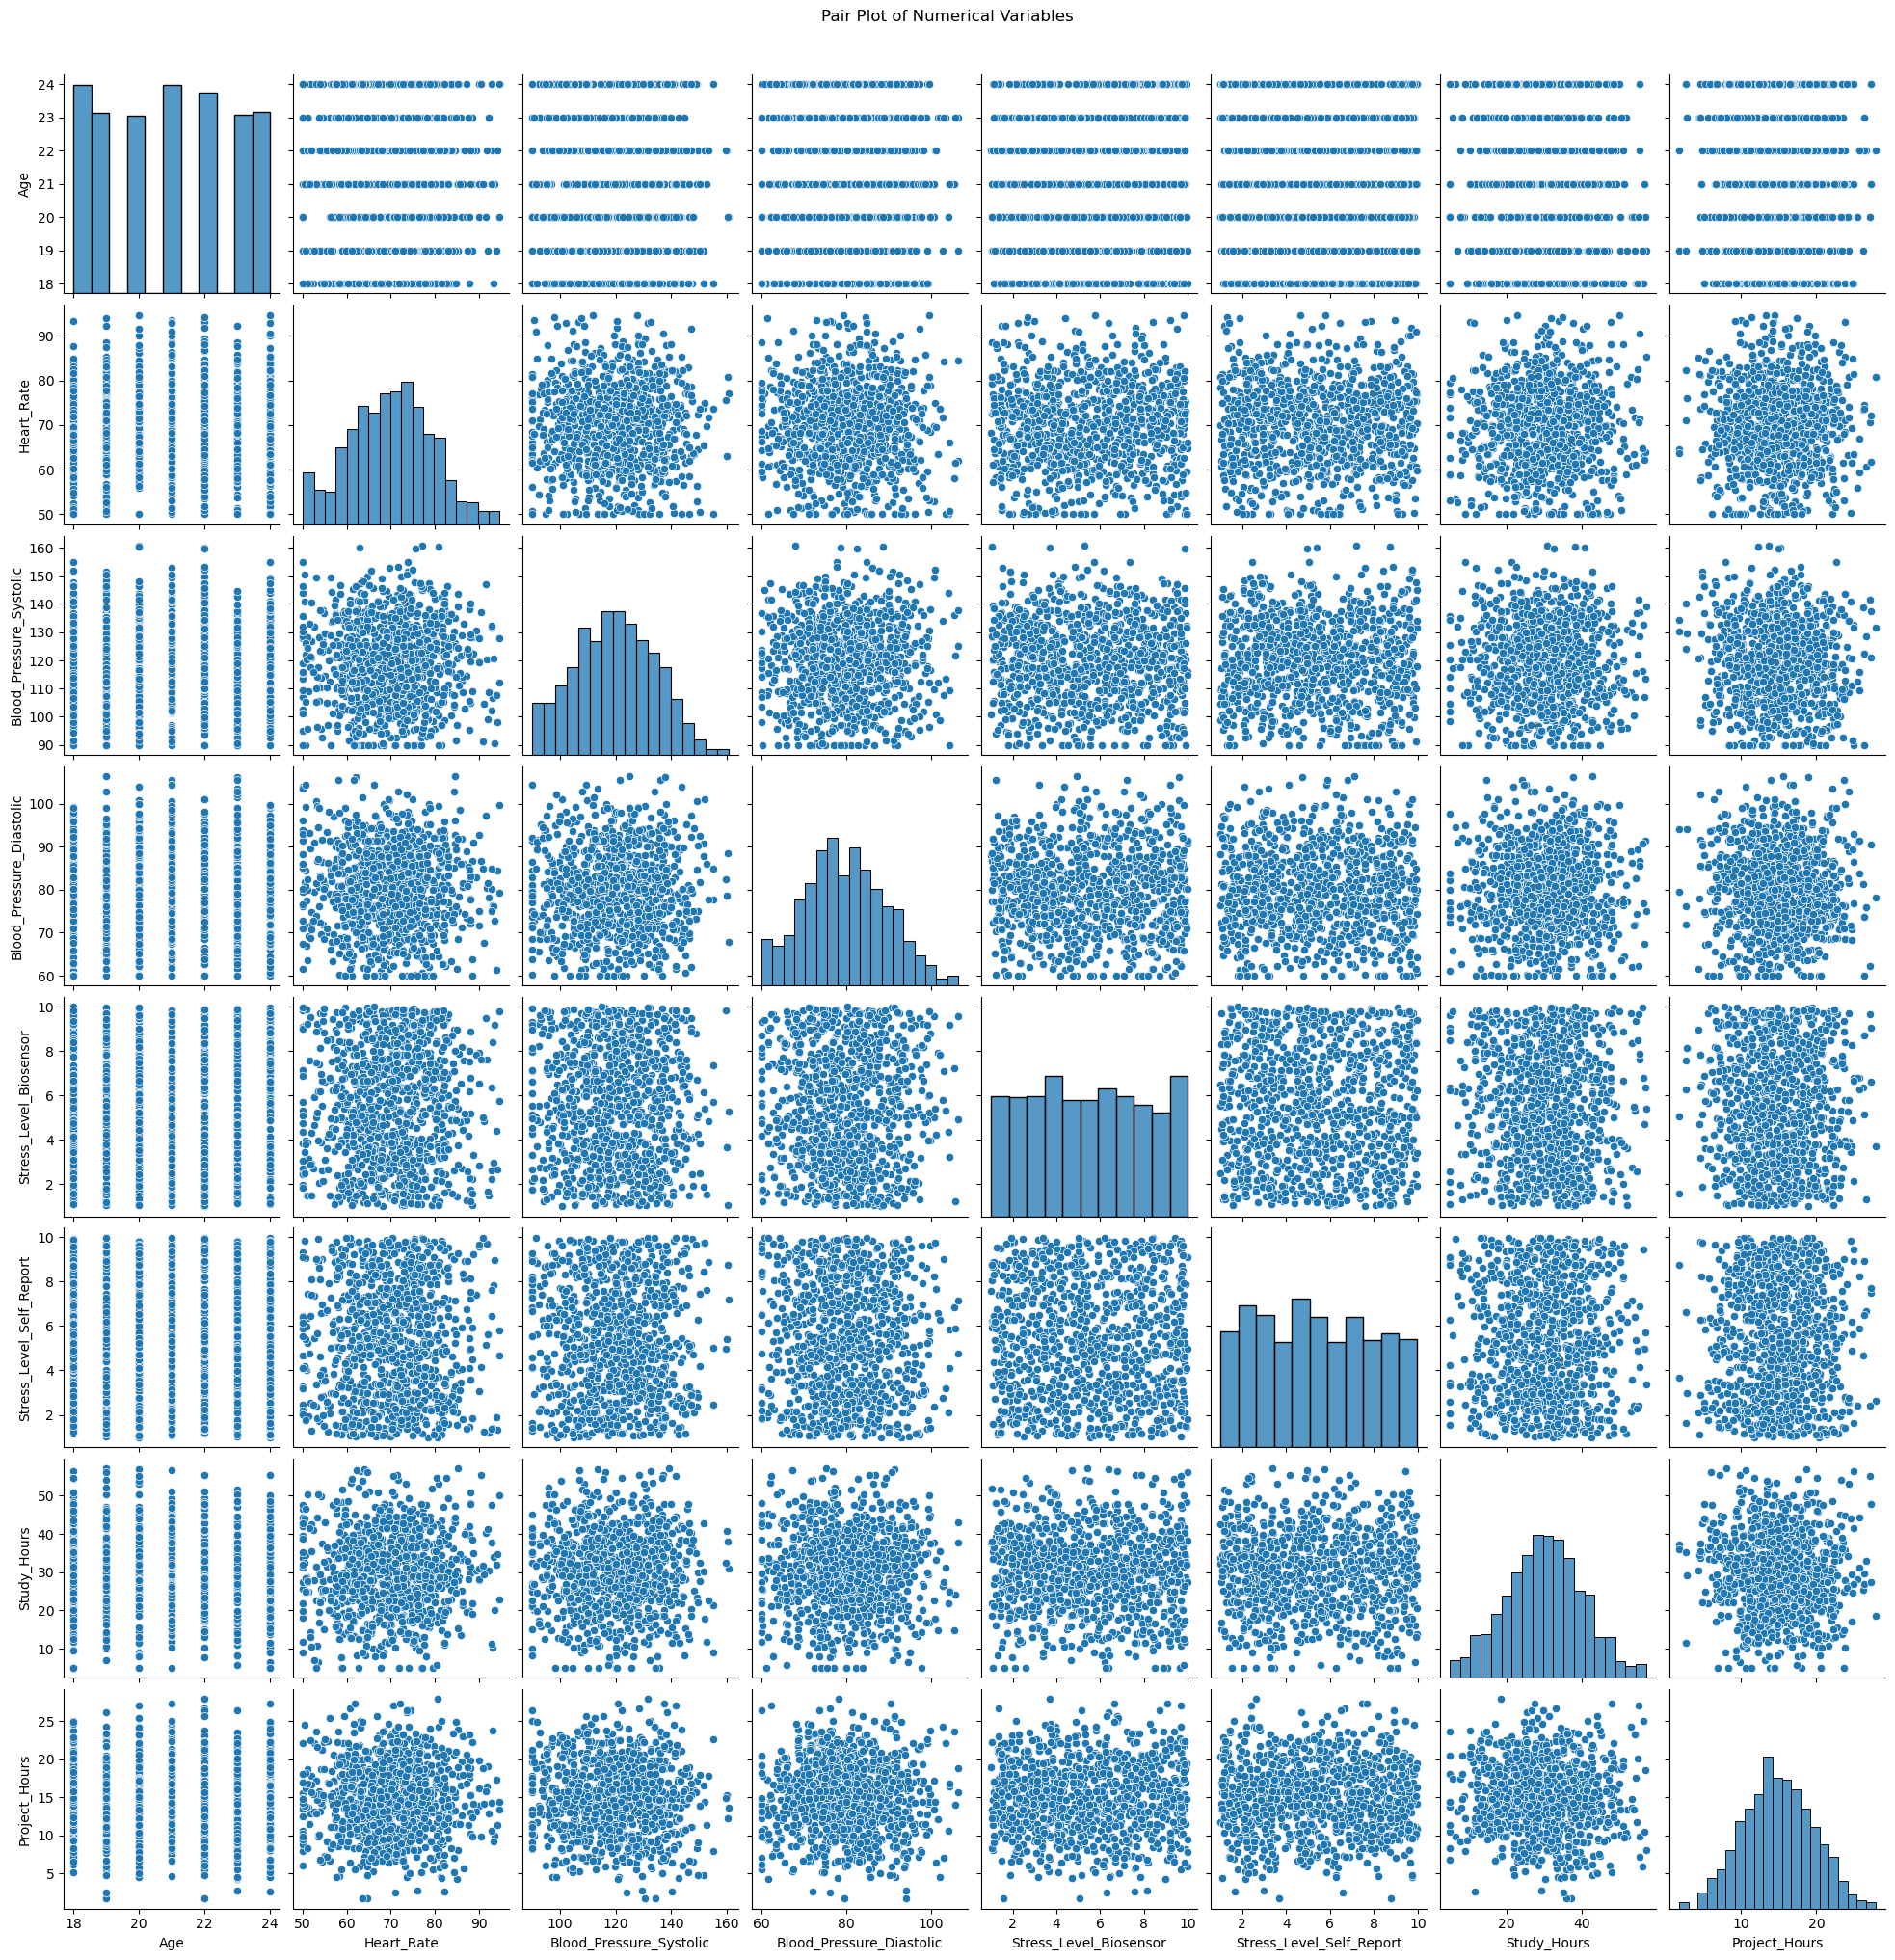

In [19]:
#pair plot
sns.pairplot(cleaned_df[numerical_var])
plt.suptitle('Pair Plot of Numerical Variables', y=1.02)
plt.show()

The visualization supports our findings. 

Implications:
- This simplifies our analysis since we don't have to account for interdependencies between variables.
- This might lead to unique information to our predictive models. This could also improve the model's ability to capture diverse patterns in the data.
- Algorithms such as Random Forest and Gradient Boosting can help identify the importance of each feature without being affected by multicollinearity.

The last thing to check out now is to see how the numerical features correlate to the target variable.

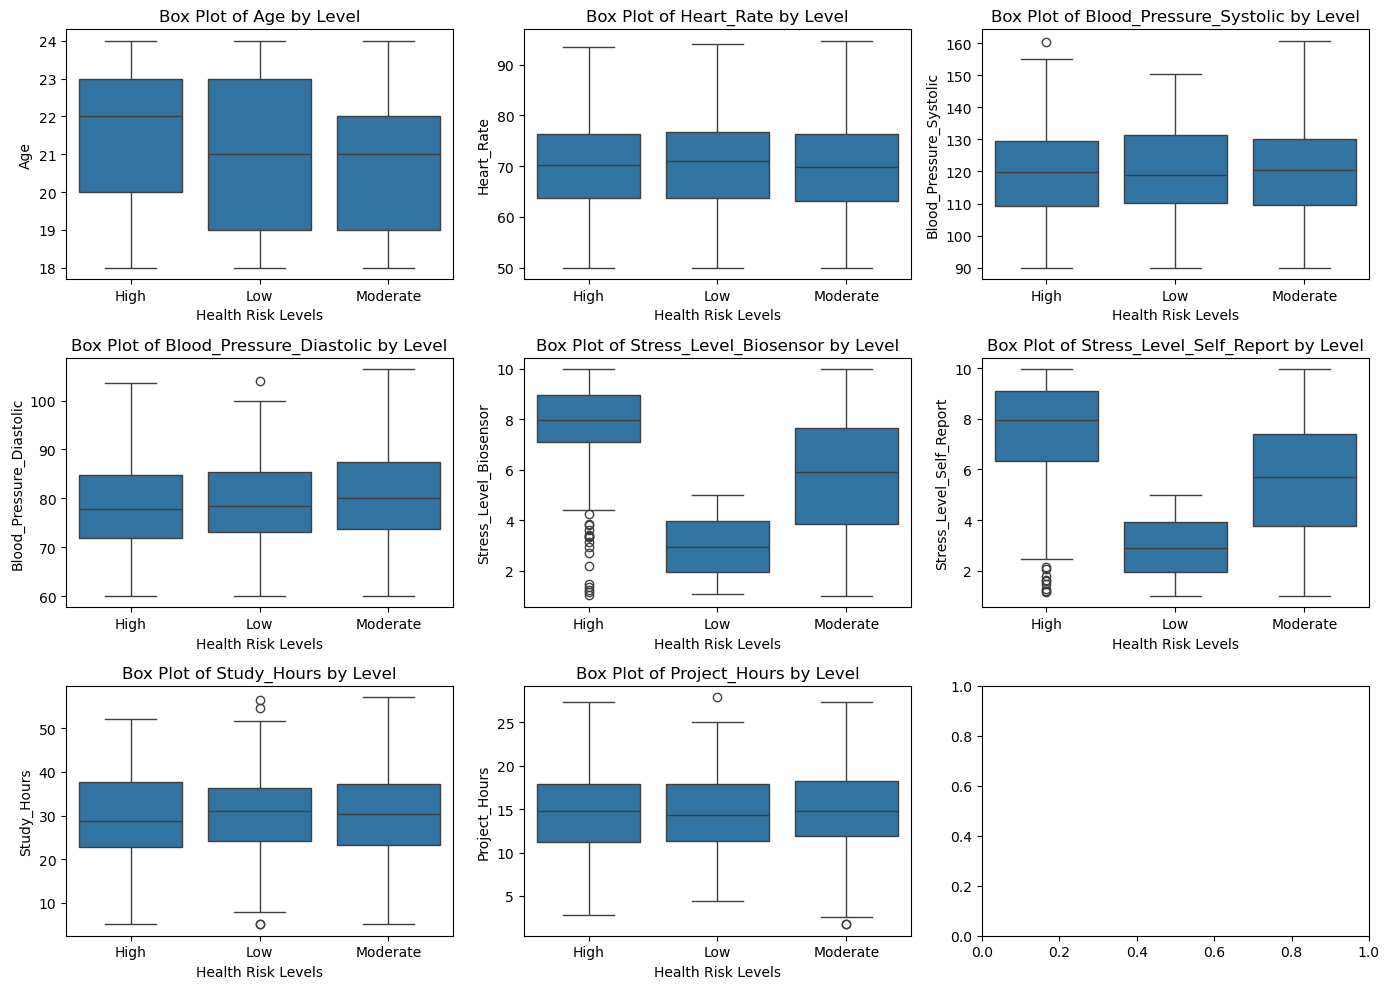

In [20]:
# subplots set up
rows = 3
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(14, 10)) 
axes = axes.flatten()


# Create Box Plots
i = 0
for var in numerical_var:

    #create boxplot for each numerical variable grouped by the target variable
    sns.boxplot(x=cleaned_df['Health_Risk_Level'], 
                y=cleaned_df[var], 
               ax = axes[i])
    axes[i].set_title(f'Box Plot of {var} by Level')
    axes[i].set_xlabel('Health Risk Levels')
    axes[i].set_ylabel(var)
    i += 1
    
    
plt.tight_layout()
plt.show()

Here is what I've noted:
- The median age for high risk level is higher compared to moderate and low, in which they (moderate and low) have similar medians. This difference suggests there may be a correlation between Age and Health_Risk_Levels.
    - The longer box between Age and Low suggests a wider age range among individuals with low health risk, indicating more variability in ages within this group. The shorter boxes for High and Moderate suggests less variability in ages among individuals in those risk levels.
- Median Heat_Rate is similar for all risk levels. The boxes are all relatively short, indicating low variability.
- Median blood pressure is similar across all risk levels.
- Median stress levels vary greatly beyween risk levels. Median stress level is much higher in the high risk category, then in moderate, then low for both types of stress levels. We also see quite a bit of outliers in the High risk level. These large differences suggests a relationship between stress levels and health risk levels.
    - It should also be noted that there are quite a bit of outliers, particularly in the High risk level.
- Median study hours is relatively consistent across risk levels. Similar can be said about project hours.

### Categorical

Now, let's look at the categorical variable in more detail.

In [21]:
#look at value counts for non-numerical columns

#create vector for non-numeric columns
obj_var = ['Gender', 'Physical_Activity', 'Sleep_Quality', 'Mood', 'Health_Risk_Level']

#iterate through each variable and print
for i in obj_var:
    print(cleaned_df[i].value_counts(), '\n')

Gender
M    506
F    473
Name: count, dtype: int64 

Physical_Activity
Moderate    475
Low         299
High        205
Name: count, dtype: int64 

Sleep_Quality
Good        467
Moderate    308
Poor        204
Name: count, dtype: int64 

Mood
Neutral     406
Happy       390
Stressed    183
Name: count, dtype: int64 

Health_Risk_Level
Moderate    656
Low         186
High        137
Name: count, dtype: int64 



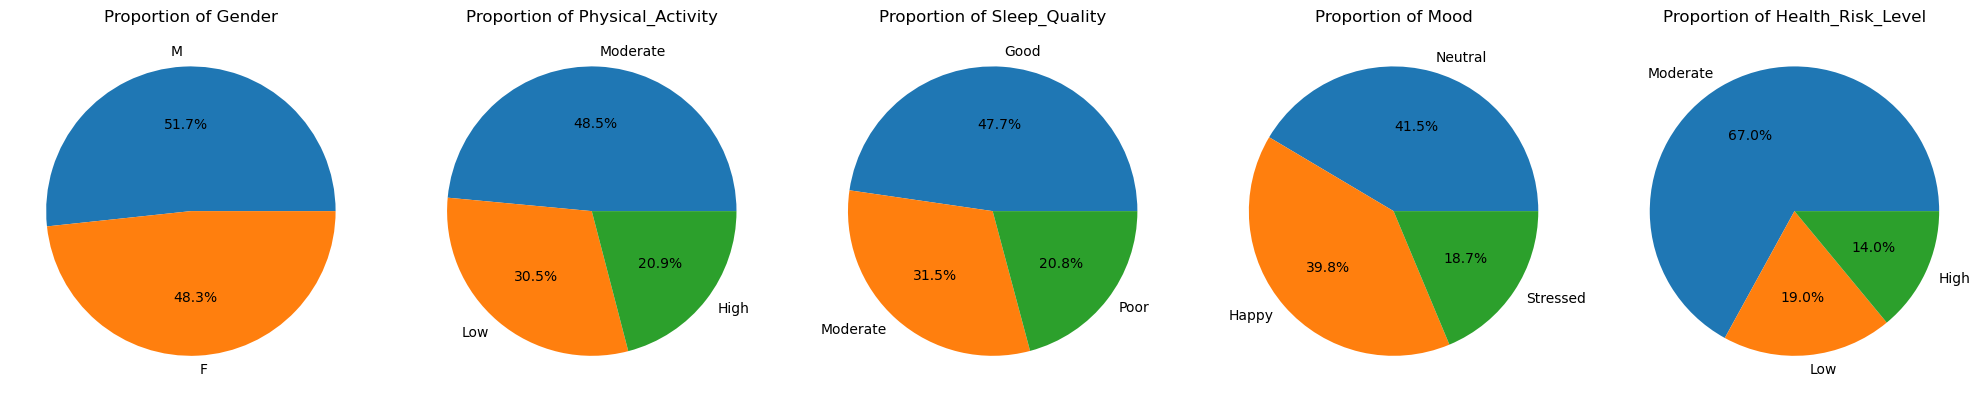

In [22]:
#pie chart to visualize category distribution

#create subplots: a grid of plots, one for each variable
fig, axes = plt.subplots(1, len(obj_var), figsize=(20, 5))

#loop through each variable in the list
for idx, var in enumerate(obj_var):
    cleaned_df[var].value_counts().plot.pie(autopct='%1.1f%%', ax=axes[idx])
    axes[idx].set_title(f'Proportion of {var}')
    axes[idx].set_ylabel('')  #remove y-axis label for cleaner look

plt.tight_layout()
plt.show()

Items of note:
- The gender distribution is fairly balanced, with only slightly more males. This ensures that gender-based analyses can be conducted without significant bias.
- Most students engage in moderate physical activity, with fewer participating in high or low activity. This suggests a potential area of intervention to increase physical activity levels among students.
- While many student report good sleep quality, a significant  number experience moderate or poor sleep. This could impact their overall well-being and academic performance, highlighting the need for sleep improvement initiatives.
- The majority of students reported happy or neutral moods, with a smaller proportion feeling stressed. Understanding factors contributing to stress can help in providing better mental health support.
- The majority of students are classified as moderate health risk, with fewer in low and even less in high. This distribution can help focus health interventions on those in the moderate and high risk groups.

Next step is to check correlation between categorical variables.

In [23]:
#function to calculate Chi-Square p-value
def chi_square_test(x, y):
    #create contigency table from the two variables
    contingency_table = pd.crosstab(x, y)
    #perform Ch-Square Test for independence
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    #return p-value
    return p

#loop through unique pairs of variables
for i in range(len(obj_var)):
    for j in range(i + 1, len(obj_var)):
        #select the two variables for the current pair
        var1 = obj_var[i]
        var2 = obj_var[j]

        #calculate Chi-Square p-value
        p_value = chi_square_test(cleaned_df[var1], cleaned_df[var2])
        print(f'Chi-Square p-value for {var1} and {var2}: {p_value}')

Chi-Square p-value for Gender and Physical_Activity: 0.034586142078450614
Chi-Square p-value for Gender and Sleep_Quality: 0.015100291529196634
Chi-Square p-value for Gender and Mood: 0.44263321443120285
Chi-Square p-value for Gender and Health_Risk_Level: 0.5580824884585867
Chi-Square p-value for Physical_Activity and Sleep_Quality: 0.8204041135148793
Chi-Square p-value for Physical_Activity and Mood: 0.6261103118512352
Chi-Square p-value for Physical_Activity and Health_Risk_Level: 1.930445735375106e-16
Chi-Square p-value for Sleep_Quality and Mood: 0.8950487122842119
Chi-Square p-value for Sleep_Quality and Health_Risk_Level: 6.440596238339458e-10
Chi-Square p-value for Mood and Health_Risk_Level: 0.26315918913566794


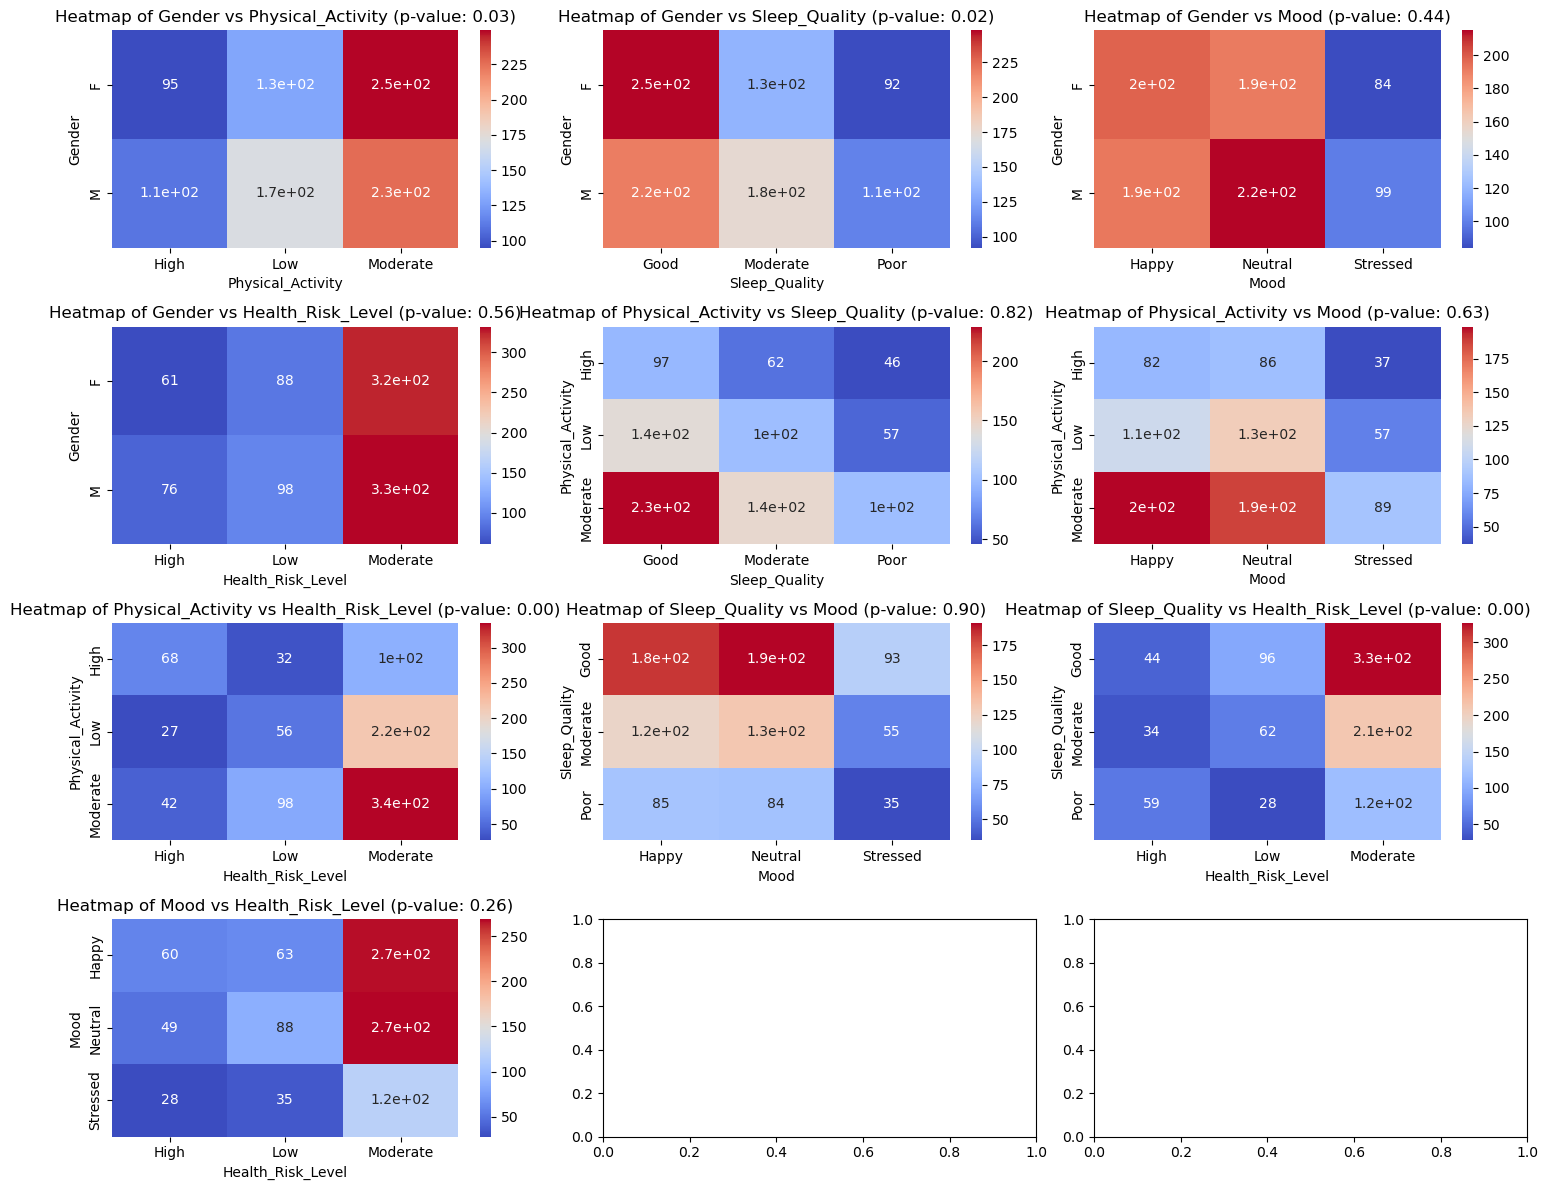

In [24]:
#Heatmap comparing each of the categorical variables to each other
#These heatmaps will visualize the frequency of occurrences for each pair of variable levels

#plotting heatmaps with p-values as annotations
rows = 4
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 12)) 
axes = axes.flatten()

k = 0
for i in range(len(obj_var)):  #iterates over list of variables from beginning to end
    for j in range(i + 1, len(obj_var)):  #ensures each pair is only visualized once
        var1 = obj_var[i]
        var2 = obj_var[j]
        
        #create a crosstab
        crosstab = pd.crosstab(cleaned_df[var1], cleaned_df[var2])
        
        #calculate Chi-Square p-value
        p_value = chi_square_test(cleaned_df[var1], cleaned_df[var2])
        
        #plot the heatmap
        sns.heatmap(crosstab, annot=True, cmap='coolwarm', ax=axes[k])
        axes[k].set_title(f'Heatmap of {var1} vs {var2} (p-value: {p_value:.2f})')
        k += 1
        
plt.tight_layout()
plt.show()

Interpretation of Chi-Square p-value: if the p-value is < 0.05, it suggests there is a statistically significant association between the two variables. If > 0.05, it indicates that observed association is likely due to chance.

Looking at the p-values, we can see that there are correlations between:
- Gender and Physical_Activity
- Gender and Sleep_Quality
- Physical_Activity and Health_Risk_Level
- Sleep_Quality and Health_Risk_Level

Insights:
- Gender has significant associations with physical activity and sleep quality. Tailored interventions focusing on these factors may be beneficial.
- There is a strong link between physical activity and health risk level. Promoting physical activity can significantly reduce health risks.
- Good sleep quality is strongly associated with health risk levels. Programs improving sleep quality can enhance overall health.

Note that the heatmaps visualize the frequency of occurrences for each pair of variable levels. As the occurrences increase, the color becomes a darker shade of red. These can be used to identify potential associations or patterns between the variables, but show no correlations or statistical significance.

# Getting Ready to Model

#### Split the data

First we separate the our features and target variable into a feature matrix and a target vector.

In [25]:
#define feature matrix and target vector
X = cleaned_df.drop(columns = ["Health_Risk_Level"])
y = cleaned_df["Health_Risk_Level"]

In [26]:
#check sizes
print(f'cleaned_df size: {cleaned_df.shape}')
print(f'feature matrix size: {X.shape}')
print(f'target vector size: {y.shape}')

cleaned_df size: (979, 13)
feature matrix size: (979, 12)
target vector size: (979,)


In [27]:
X.head()

Age Gender  Heart_Rate  Blood_Pressure_Systolic  Blood_Pressure_Diastolic  \
0   24      M   50.663217               122.173015                 84.419860   
1   21      F   57.926042               110.778407                 75.696145   
2   22      M   59.294219               109.375673                 83.803814   
3   24      M   76.826232               125.142227                 78.091587   
4   20      M   68.342769               107.515592                 80.674937   

   Stress_Level_Biosensor  Stress_Level_Self_Report Physical_Activity  \
0                3.137350                  9.028669              High   
1                3.699078                  5.819697          Moderate   
2                6.785156                  5.892360               Low   
3                6.408509                  6.884001              High   
4                7.264719                  4.483450          Moderate   

  Sleep_Quality      Mood  Study_Hours  Project_Hours  
0      Moderate     Happy    34.520973      16.800956  
1          Good  Stressed    16.763846      15.791154  
2      Moderate     Happy    44.203798      25.678437  
3          Poor     Happy    21.776645      20.808391  
4          Poor     Happy     8.964999      15.194045

Next step is to split the data into a training set (80%), and validation set for hyperparameter tuning (10%) and a test set for a final model performance (10%). Since we have class imbalance in the target variable, we want to make sure that each target split contains the same distribution of classes.

In [28]:
#split data into a training set and a temp set
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 12)

#split the temp set into a validation set and final test set
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, stratify = y_temp, random_state = 12)

Now to ensure that that the split occurred as desired. First we check the sizes of our feature sets

In [29]:
#check number of instances in each split
print(f"Training set size: {X_train.shape[0]}") #X_train.shape[0] gives the number of rows in the trainin set
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 783
Validation set size: 98
Test set size: 98


In [30]:
print(783/979)
print(98/979)

0.7997957099080695
0.10010214504596528


Next, we ensure that each target variable has the same distribution.

In [31]:
#print class distribution as percent
print("Class distribution in Training Set:") #training set
print(y_train.value_counts(normalize=True))  #normalized (percentages)

print("\nClass distribution in Validation Set:") #validation set
print(y_val.value_counts(normalize=True))

print("\nClass distribution in Test Set:") #test set
print(y_test.value_counts(normalize=True))

Class distribution in Training Set:
Health_Risk_Level
Moderate    0.670498
Low         0.190294
High        0.139208
Name: proportion, dtype: float64

Class distribution in Validation Set:
Health_Risk_Level
Moderate    0.663265
Low         0.193878
High        0.142857
Name: proportion, dtype: float64

Class distribution in Test Set:
Health_Risk_Level
Moderate    0.673469
Low         0.183673
High        0.142857
Name: proportion, dtype: float64


It looks like the data has been split relatively evenly, retaining the distribution of categories quite well.

#### Preprocess the data

Now that the data has been split, let's go ahead and preprocess it. We begin by encoding the categorical data, then scaling using a standard scaler.
- It should be noted that tree-based models don't require as much preprocessing, but to ensure consistency across different models (tree-based, KNN, SVM), it's simpler to preprocess the data once and use the preprocessed data for all models.
- LabelEncoder converts each category into a unique integer. This is preferred for the target variable.
- pd.get_dummies is used for one-hot encoding. This is preferred for categorical features.
- Aligning ensures all datasets have the same features.

In [32]:
#encode categorical features - uses one-hot encoding
#allows the models to interpret each category as a distinct entity - preferred for KNN and SVM
X_train_encode = pd.get_dummies(X_train)
X_val_encode = pd.get_dummies(X_val)
X_test_encode = pd.get_dummies(X_test)

#align validation and test sets with training set - ensures same columns
X_val_encode = X_val_encode.reindex(columns = X_train_encode.columns, fill_value = 0)
X_test_encode = X_test_encode.reindex(columns = X_train_encode.columns, fill_value = 0)

#initialize and fit scaler on training set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encode)

#transform validation and test data
X_val_scaled = scaler.transform(X_val_encode)
X_test_scaled = scaler.transform(X_test_encode)

#manually set class order
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(["Low", "Moderate", "High"])  #custom order

#encode labels - this method is preferrred for target as it assigns a unique integer to each class
y_train_encode = label_encoder.transform(y_train)
y_val_encode = label_encoder.transform(y_val)
y_test_encode = label_encoder.transform(y_test)

#check mapping
label_mapping = dict(enumerate(label_encoder.classes_))
print("Label Encoding Mapping:", label_mapping)

#rename matrices and vectors for ease of use - could  be done better, but didn't want to overwrite previous train, val, and test
X_train2 = X_train_scaled
X_val2 = X_val_scaled
X_test2 = X_test_scaled

y_train2 = y_train_encode
y_val2 = y_val_encode
y_test2 = y_test_encode

Label Encoding Mapping: {0: 'Low', 1: 'Moderate', 2: 'High'}


Now that we have our data preprocess, it's time to begin the modeling process.

# Tree-Based Models

## Decision Tree

### Initializing and Training the Decision Tree

Let's sart with a default decision tree.

In [33]:
#initialize decision tree
dt = DecisionTreeClassifier(random_state = 13)

#train the model
dt.fit(X_train2, y_train2)

#make predictions on validation set
y_pred = dt.predict(X_val2)

#evaluate model
v_acc = accuracy_score(y_val2, y_pred)
v_f1 = f1_score(y_val2, y_pred, average='weighted')
v_precision = precision_score(y_val2, y_pred, average='weighted')
v_recall = recall_score(y_val2, y_pred, average='weighted')
confusion_crosstab = pd.crosstab(y_val2, y_pred, rownames=['Actual'], colnames=['Predicted'])

print(f'Decision Tree Validation Accuracy: {v_acc:.2f}')
print(f'Decision Tree Weighted F1-Score: {v_f1:.2f}')
print(f'Decision Tree Weighted Precision: {v_precision:.2f}')
print(f'Decision Tree Weighted Recall: {v_recall:.2f}')
print('Confusion Matrix:')
print(confusion_crosstab)

Decision Tree Validation Accuracy: 0.97
Decision Tree Weighted F1-Score: 0.97
Decision Tree Weighted Precision: 0.97
Decision Tree Weighted Recall: 0.97
Confusion Matrix:
Predicted   0   1   2
Actual               
0          19   0   0
1           0  64   1
2           0   2  12


In [34]:
#perform cross-validation
cv_scores = cross_val_score(dt, X_train2, y_train2, cv=5, scoring='accuracy')
print(f'Cross-Validation Accuracy: {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})')

Cross-Validation Accuracy: 0.99 (+/- 0.01)


Here is what our metrics tell us:
- We have a 97% overall accuracy, meaning the model performs well in correctly classifying instances.
- The F1-Score is quite high, indicating a balance between precision and recall.
- High precision indicates that when our model predicts a class, it's likely to be correct.
- A high recall suggests that our model is effectively capturing most of the actual instances.
- The F1-Score, Precision, and Recall being 97% indicates that the model maintains a good balance between precision and recall across different classes.
- There were no misclassifications for Low risk levels, which means the model is confident and accurate predicting this class.
- Note that 2 High health risk levels were predicted as Moderate and 1 Moderate instance was classified as High. This may be because the model finds it harder to distinguish between Moderate and High risk levels - especially if the boundary between these two classes are less clear compared to Low and the other two.
- If predicting High-Risk as Moderate means missing out on critical intervention actions, this could be potentially dangerous since the instance wouldn't receive the care they require. This also depends on the care received for Moderate and High.
    - If high risk cases receive significantly different care than moderate, even a small misclassification rate could have serious consequences. A recall-focused approach might be beneficial.
 
Cross-Validation score:
- A mean accuracy of 99% indicates that the model consistently performs well across the different folds. This suggests that the model generalizes well to unseen data isn't overfitting to the training data.
- The low standard deviation indicates that the performance of the model is stable and consistent across the different folds. This means that the model's performance doesn't vary much with different subsets of the data.

#### Initial Visualization of the Decsion Tree

Let's take a look at the model, and take a look at feature importance.

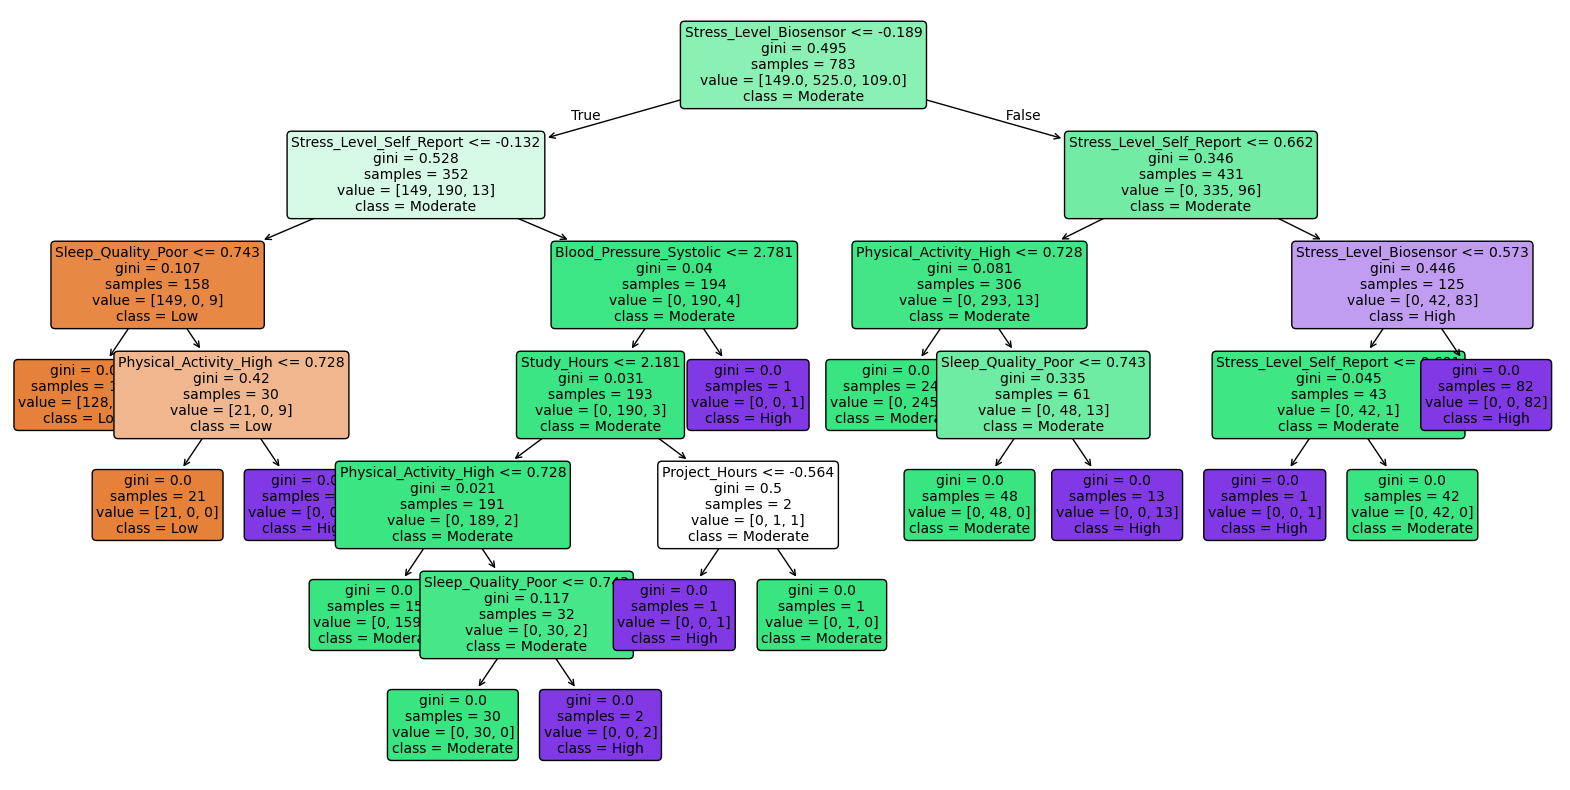

In [35]:
#set figure size
plt.figure(figsize=(20, 10))

#plot the decision tree
plot_tree(dt, 
          feature_names=X_train_encode.columns,  #make sure you pass the correct feature names
          class_names=label_encoder.classes_,    #class names from LabelEncoder
          filled=True, rounded=True, fontsize=10)
#show plot
plt.show()

Note: The small tree makes it relatively easy to follow.
- Stress levels seem to be the most important feature in predicting health risk levels.
- Poor sleep quality, blood pressure, and high physical activity seems to be the next important features.
- We also see study hours and project hours play a role.
- With a low depth, the tree has enough complexity to capture the nuances in the data without overfitting.
- The leaf nodes indicate the final classification for different combinations of features, providing clear decision paths.

#### Initial Decision Tree Structure Format

Looking at the tree structure can help determine which hyperparameters to tune and around which values to use.

In [36]:
print("Depth of the decision tree: ", dt.tree_.max_depth)#depth of tree
print("Number of nodes: ", dt.tree_.node_count) #number of nodes
print("Number of splits: ", dt.tree_.n_leaves) #number of splits

Depth of the decision tree:  6
Number of nodes:  29
Number of splits:  15


#### Initial Decision Tree Feature Importance

In [37]:
#get feature importanc scores
feature_importance = dt.feature_importances_

#create dataframe to visualize feature importance scores
importance_dt = pd.DataFrame({'Feature': X_train_encode.columns, 'Importance': feature_importance})

#sort by importance in descending order
importance_dt = importance_dt.sort_values(by='Importance', ascending=False)

#display top features
print(importance_dt.head(8))

                     Feature  Importance
5   Stress_Level_Self_Report    0.597734
4     Stress_Level_Biosensor    0.273982
15        Sleep_Quality_Poor    0.073772
10    Physical_Activity_High    0.044506
2    Blood_Pressure_Systolic    0.004977
7              Project_Hours    0.002581
6                Study_Hours    0.002448
0                        Age    0.000000


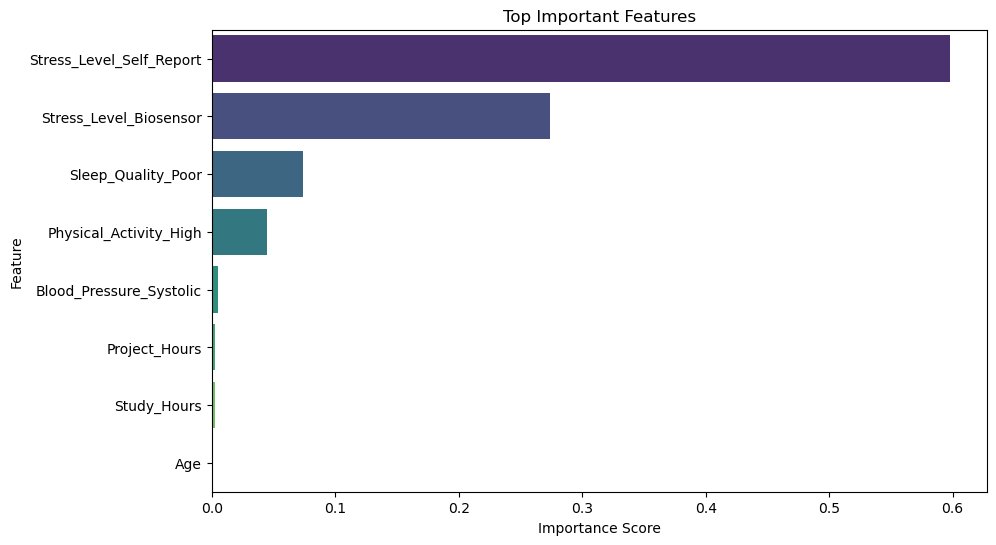

In [38]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_dt[:8], hue='Feature', palette="viridis", legend=False)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Top Important Features')
plt.show()

Observations from the output:
- Stress levels are the most significant features.
- Poor sleep quality and high physical activity are also shown to have some significance.
- Systolic blood pressure and project/study hours have minimal significance.
- All other features are deemed to have no importance.

Interpretations:
- Stress levels dominate predictions. This suggests interventions targeting stress reduction could significantly improve student health.
- Sleep quality matters, but noticing that Sleep_Quality_Good doesn't contribute to predictions implies that improving poor sleep quality could also prove helpful in reducing risk levels.
- Physical_Activity_High has some relevance, while Studey_Hours and Project_Hours have very little. This may indicate that mental and physical well-being are more indicative of health risk than academic load.
  - Note that academic load, along with physical activities, could play a significant role in stress levels.

### Improving the Decision Tree

Now that we have out first tree, let's try to optimize it using grid search.
- GridSearchCV will help determine the optmial combination of hyperparameters by testing all possible combinations of values defined in a grid.
- Since the initial tree had a max depth of 6, we'll try a range around that value to see if a slightly more shallow or deeper tree performs better.
- We'll tune min_samples_split and min_samples_leaf to control the number of splits and leaves
- We'll also check criterion for splitting.

#### Grid Search CV for Decision Tree

In [39]:
#define parameter grid
params = {
    'max_depth': [4, 6, 8, 10], #max depth of tree
    'min_samples_split': [2, 5, 10, 20], #values to control the number of splits
    'min_samples_leaf': [1, 5, 10, 20], #values to control minimum samples per leaf node
    'criterion': ['gini', 'entropy'] #different splitting criteria
}

In [40]:
#initialize decision tree
dt = DecisionTreeClassifier(random_state = 13)

#initialize grid search
grid_search = GridSearchCV(estimator = dt, param_grid = params, cv = 10, scoring = 'f1_weighted')

In [42]:
#fit grid search to training data and record time
grid_search.fit(X_train2, y_train2)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=13),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8, 10],
                         'min_samples_leaf': [1, 5, 10, 20],
                         'min_samples_split': [2, 5, 10, 20]},
             scoring='f1_weighted')

In [43]:
#get best parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

Best Parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}


#### Training and Evaluating Tuned Decision Tree

In [44]:
#initialize model with best parameters
dt_tune = DecisionTreeClassifier(
    random_state=13,
    criterion=best_params['criterion'],
    max_depth=best_params['max_depth'],
    min_samples_leaf=best_params['min_samples_leaf'],
    min_samples_split=best_params['min_samples_split']
)

#train the model
dt_tune.fit(X_train2, y_train2)

#make predictions on validation set
y_pred = dt_tune.predict(X_val2)

#evaluate model
v_acc = accuracy_score(y_val2, y_pred)
v_f1 = f1_score(y_val2, y_pred, average='weighted')
v_precision = precision_score(y_val2, y_pred, average='weighted')
v_recall = recall_score(y_val2, y_pred, average='weighted')
confusion_crosstab = pd.crosstab(y_val2, y_pred, rownames=['Actual'], colnames=['Predicted'])

print(f'Decision Tree (Tuned) Validation Accuracy: {v_acc:.2f}')
print(f'Decision Tree (Tuned) Weighted F1-Score: {v_f1:.2f}')
print(f'Decision Tree (Tuned) Weighted Precision: {v_precision:.2f}')
print(f'Decision Tree (Tuned) Weighted Recall: {v_recall:.2f}')
print('Confusion Matrix:')
print(confusion_crosstab)

Decision Tree (Tuned) Validation Accuracy: 0.97
Decision Tree (Tuned) Weighted F1-Score: 0.97
Decision Tree (Tuned) Weighted Precision: 0.97
Decision Tree (Tuned) Weighted Recall: 0.97
Confusion Matrix:
Predicted   0   1   2
Actual               
0          19   0   0
1           0  64   1
2           0   2  12


In [45]:
#perform cross-validation
cv_scores = cross_val_score(dt_tune, X_train2, y_train2, cv=5, scoring='accuracy')
print(f'Cross-Validation Accuracy: {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})')

Cross-Validation Accuracy: 1.00 (+/- 0.01)


No clear differences in evaluation metrics. Even the misclassifications are the same. Also note that the cross-validation accuracy has increased.

#### Visualization of Tuned Decision Tree

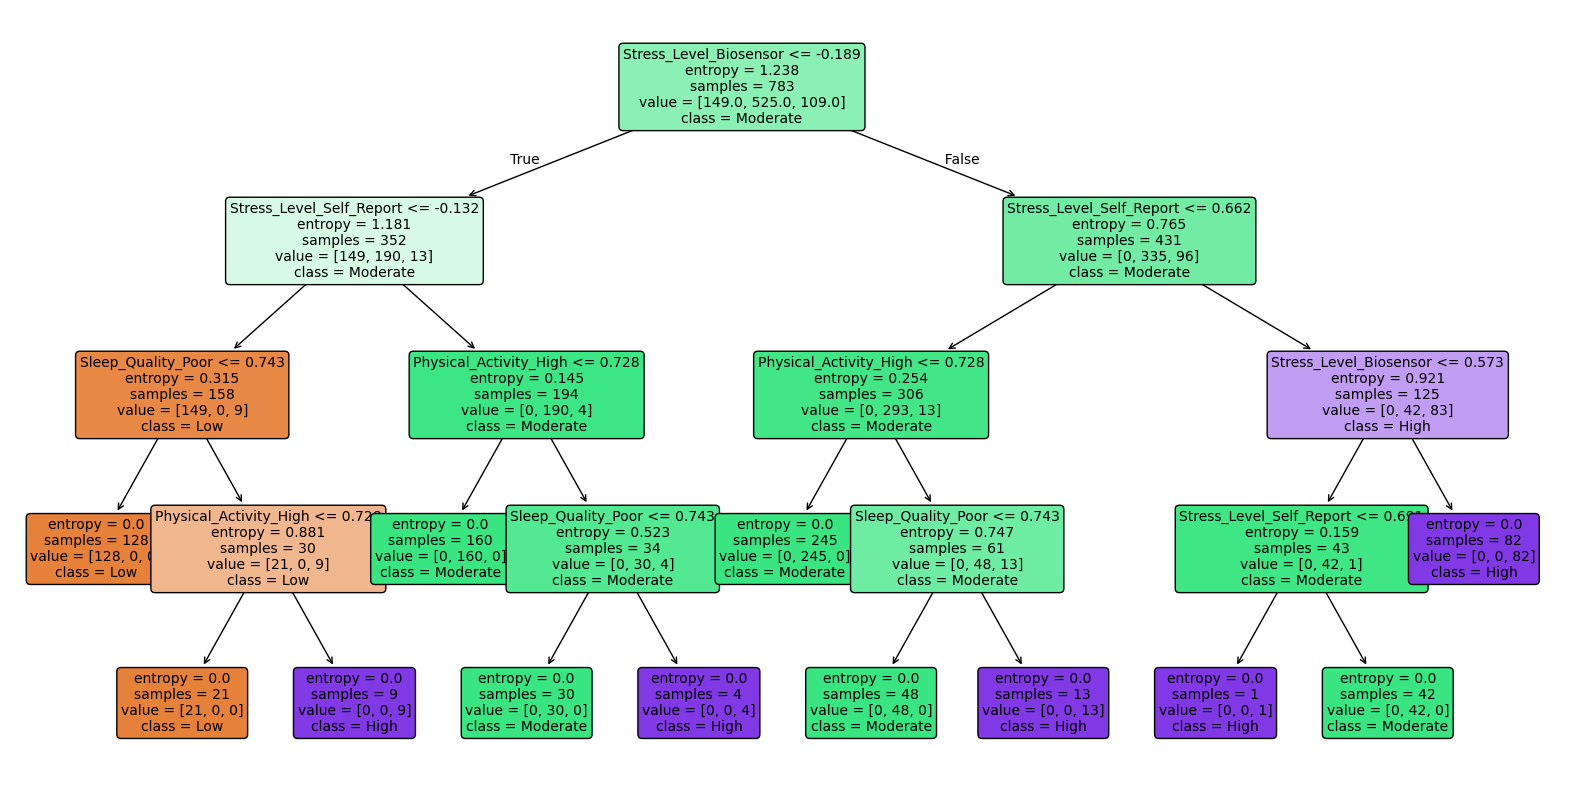

In [46]:
#set figure size
plt.figure(figsize=(20, 10))

#plot the decision tree
plot_tree(dt_tune, 
          feature_names=X_train_encode.columns,  #make sure you pass the correct feature names
          class_names=label_encoder.classes_,    #class names from LabelEncoder
          filled=True, rounded=True, fontsize=10)
#show plot
plt.show()

This tree looks less complex than what we got with our default decision tree. We can see that stress, poor sleep quality, and high physical activity are still the most important features.

#### Tuned Decision Tree Structure Format

In [47]:
print("Depth of the decision tree: ", dt_tune.tree_.max_depth)#depth of tree
print("Number of nodes: ", dt_tune.tree_.node_count) #number of nodes
print("Number of splits: ", dt_tune.tree_.n_leaves) #number of splits

Depth of the decision tree:  4
Number of nodes:  23
Number of splits:  12


#### Tuned Decision Tree Feature Importance

In [48]:
#get feature importanc scores
feature_importance = dt_tune.feature_importances_

#create dataframe to visualize feature importance scores
importance_dt_tune = pd.DataFrame({'Feature': X_train_encode.columns, 'Importance': feature_importance})

#sort by importance in descending order
importance_dt_tune = importance_dt_tune.sort_values(by='Importance', ascending=False)

#display top features
importance_dt_tune.head(8)

Feature  Importance
5   Stress_Level_Self_Report    0.496835
4     Stress_Level_Biosensor    0.342758
15        Sleep_Quality_Poor    0.089460
10    Physical_Activity_High    0.070946
0                        Age    0.000000
11     Physical_Activity_Low    0.000000
17              Mood_Neutral    0.000000
16                Mood_Happy    0.000000

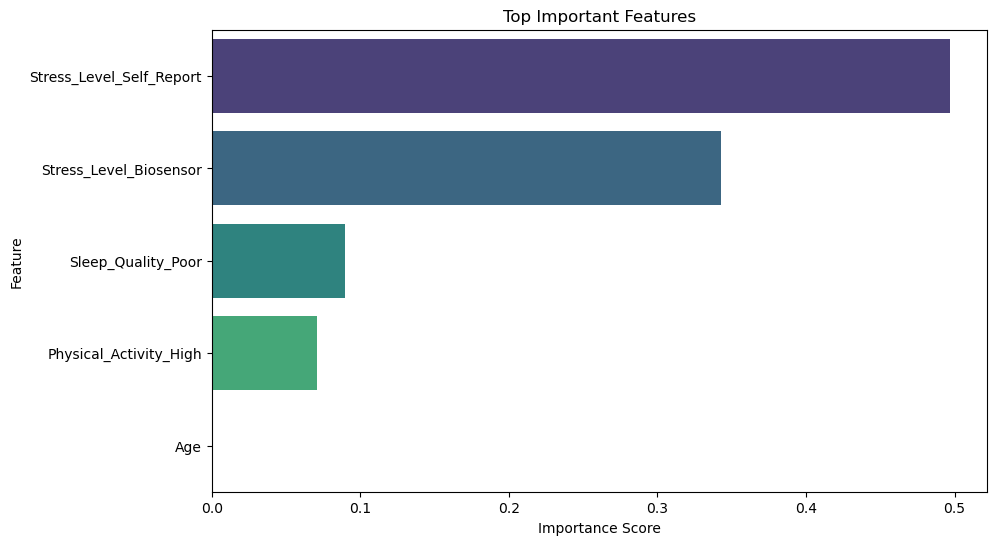

In [49]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_dt_tune[:5], hue='Feature', palette="viridis", legend=False)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Top Important Features')
plt.show()

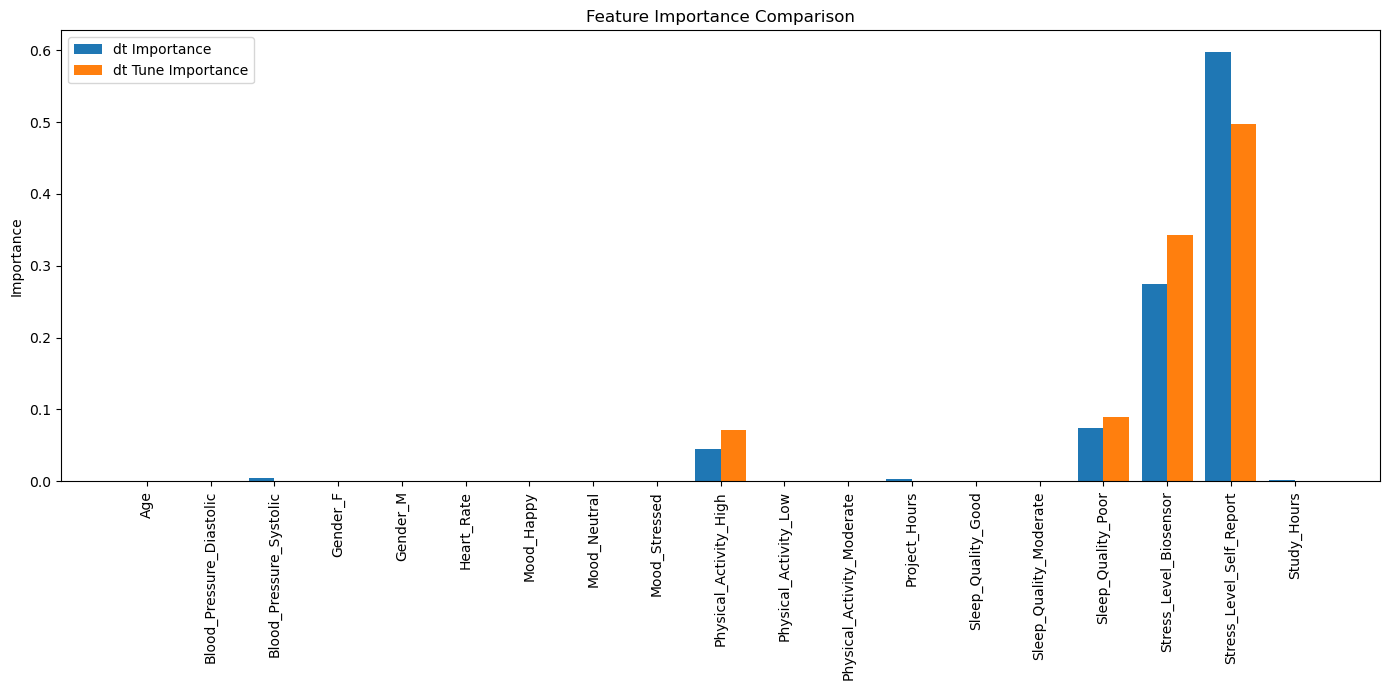

In [50]:
#ensure feature columns are same in both importance dataframes 
importance_dt = importance_dt.sort_values(by='Feature').reset_index(drop=True)
importance_dt_tune = importance_dt_tune.sort_values(by='Feature').reset_index(drop=True)

#merge dataframes on feature column
df_compare = pd.merge(importance_dt, importance_dt_tune, on='Feature', suffixes=('_dt', '_dt_tune'))

#plot comparison
fig, ax = plt.subplots(figsize=(14, 7))
width = 0.4  # width of the bars

#plot importance for initial decision tree
ax.bar(df_compare.index - width / 2, df_compare['Importance_dt'], width, label='dt Importance')

#plot importance for tuned decision tree
ax.bar(df_compare.index + width / 2, df_compare['Importance_dt_tune'], width, label='dt Tune Importance')

#set labels
ax.set_xticks(df_compare.index)
ax.set_xticklabels(df_compare['Feature'], rotation=90)
ax.set_ylabel('Importance')
ax.set_title('Feature Importance Comparison')
ax.legend()

#show plot
plt.tight_layout()
plt.show()

Feature importance is between the tuned decision tree and the initial decision tree are very similar. 
- We see that stress, poor sleep quality, and high physical activities still play an integral role.
- Blood_Pressure_Systolic, Study_Hours and Project_Hours no longer have any significance. They had minimal significance before.

Interpretation is same as before:
- Interventions targeting stress reduction could significantly improve student health.
- Improving poor sleep quality could prove helpful in reducing risk levels.
- Physical activity has an impact on health risk levels.

#### Tuned DT Final Test

The very last step is to see how this model performs with unseen data.

In [51]:
#make predictions on test set
y_pred = dt_tune.predict(X_test2)

#evaluate model
v_acc = accuracy_score(y_test2, y_pred)
v_f1 = f1_score(y_test2, y_pred, average='weighted')
v_precision = precision_score(y_test2, y_pred, average='weighted')
v_recall = recall_score(y_test2, y_pred, average='weighted')
confusion_crosstab = pd.crosstab(y_test2, y_pred, rownames=['Actual'], colnames=['Predicted'])

print(f'Decision Tree (Tuned) Test Accuracy: {v_acc:.2f}')
print(f'Decision Tree (Tuned) Weighted F1-Score: {v_f1:.2f}')
print(f'Decision Tree (Tuned) Weighted Precision: {v_precision:.2f}')
print(f'Decision Tree (Tuned) Weighted Recall: {v_recall:.2f}')
print('Confusion Matrix:')
print(confusion_crosstab)

Decision Tree (Tuned) Test Accuracy: 1.00
Decision Tree (Tuned) Weighted F1-Score: 1.00
Decision Tree (Tuned) Weighted Precision: 1.00
Decision Tree (Tuned) Weighted Recall: 1.00
Confusion Matrix:
Predicted   0   1   2
Actual               
0          18   0   0
1           0  66   0
2           0   0  14


The model perform exceptionally well on it's final test. 

## Random Forest

### Initial Random Forest

Now that we've checked out a decision tree, let's see what random forest can produce.

In [52]:
#initialize random forest
rf = RandomForestClassifier(random_state=13)

#train the model
rf.fit(X_train2, y_train2)

#make predictions on validation set
y_val_pred_rf = rf.predict(X_val2)

#evaluate random forest
rf_acc = accuracy_score(y_val2, y_val_pred_rf)
rf_f1 = f1_score(y_val2, y_val_pred_rf, average='weighted')
rf_precision = precision_score(y_val2, y_val_pred_rf, average='weighted')
rf_recall = recall_score(y_val2, y_val_pred_rf, average='weighted')
confusion_crosstab = pd.crosstab(y_val2, y_val_pred_rf, rownames = ['Actual'], colnames = ['Predicted'])

#print metrics
print(f'Random Forest Validation Accuracy: {rf_acc:.2f}')
print(f'Random Forest Weighted F1-Score: {rf_f1:.2f}')
print(f'Random Forest Weighted Precision: {rf_precision:.2f}')
print(f'Random Forest Weighted Recall: {rf_recall:.2f}')
print('Confusion Matrix:')
print(confusion_crosstab)

Random Forest Validation Accuracy: 0.98
Random Forest Weighted F1-Score: 0.98
Random Forest Weighted Precision: 0.98
Random Forest Weighted Recall: 0.98
Confusion Matrix:
Predicted   0   1   2
Actual               
0          19   0   0
1           0  65   0
2           0   2  12


In [53]:
#perform cross-validation
cv_scores = cross_val_score(rf, X_train2, y_train2, cv=5, scoring='accuracy')
print(f'Cross-Validation Accuracy: {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})')

Cross-Validation Accuracy: 0.97 (+/- 0.03)


Our initial Random Forest performed slightly better than our tuned Decision Tree.
- Only two instances were miclassified: 2 High instances were classified as Moderate.
- Overall, the performance metrics and confusion matrix indicates that the Random forest Model is performing very well, with minimal misclassifications.
- Interpretations of the metrics follow that from the Decision Tree.

Cross-Validation score:
- The CV score is 97%, indicating that this model does consistently perform well across different folds, though this score is slightly lower than what we saw with the decision tree. Regardless, the model generalizes well.
- The standard deviation is quite low, indicating that the model's performance is stable and consistent across the folds. With that said, it is slightly higher than what we saw in the decision tree.

#### Default RF Feature Importance

In [54]:
#get feature importanc scores
feature_importance = rf.feature_importances_

#create dataframe to visualize feature importance scores
importance_rf = pd.DataFrame({'Feature': X_train_encode.columns, 'Importance': feature_importance})

#sort by importance in descending order
importance_rf = importance_rf.sort_values(by='Importance', ascending=False)

#display top features
print(importance_rf)

                       Feature  Importance
5     Stress_Level_Self_Report    0.322402
4       Stress_Level_Biosensor    0.304073
3     Blood_Pressure_Diastolic    0.047011
7                Project_Hours    0.044112
1                   Heart_Rate    0.043449
2      Blood_Pressure_Systolic    0.043027
6                  Study_Hours    0.043024
10      Physical_Activity_High    0.032902
15          Sleep_Quality_Poor    0.029979
0                          Age    0.024332
12  Physical_Activity_Moderate    0.010230
16                  Mood_Happy    0.009064
11       Physical_Activity_Low    0.008071
14      Sleep_Quality_Moderate    0.007520
13          Sleep_Quality_Good    0.007221
17                Mood_Neutral    0.006994
18               Mood_Stressed    0.005967
8                     Gender_F    0.005873
9                     Gender_M    0.004749


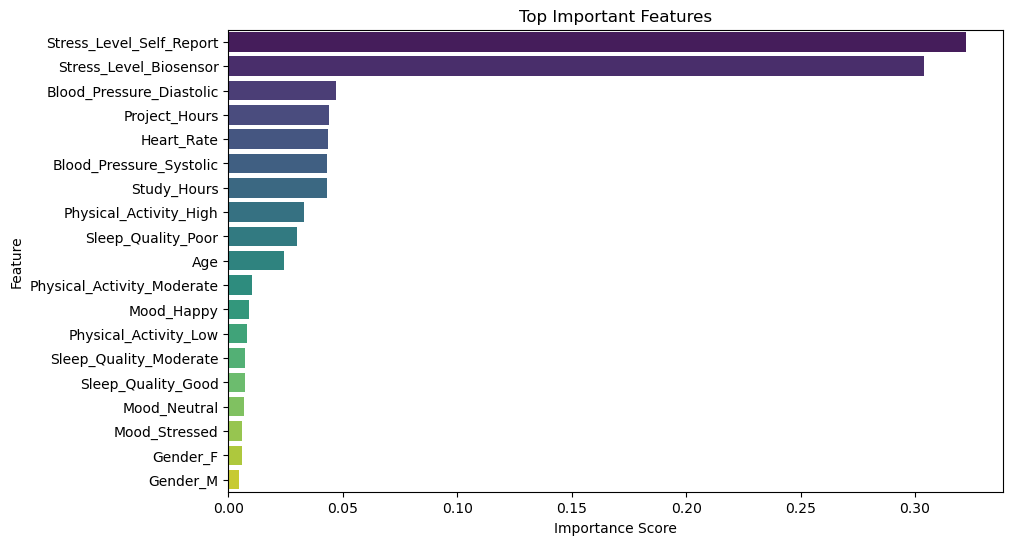

In [55]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_rf[:20], hue='Feature', palette="viridis", legend=False)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Top Important Features')
plt.show()

Feature Importance shares in similarities and distinct differences than from the decision tree.
- Stress levels are still the most important features. Combined they account for over 62% of the total feature importance.
- Blood pressure, heart rate, and project/study hours are also quite significant, accounting for over 22% of feature importance.
- High physical activity, poor sleep quality, and age also have noticeable feature importance.
- The remaining features have very low impact.

Interpretation:
- Stress levels are the most significant predictors of health risk levels. This makes sense as high stress is a known risk factor for various health issues. Interventions and techniques targeting stress reduction could significantly improve student health.
- Blood pressure and heart rate have similar contributions. These physiological metrics are likely correlated with stress and health risks. This model is capturing the physiological effects of stress, where increased stress levels may correlate with changes in heart rate and blood pressure.
- Study and project hours also play an important part. Higher study/project hours may contribute to higher stress levels, which aligns with stress being the top predictor. Additionally, students with poor health may have lower study hours due to their condition.
- High physical activity is most important among activity levels, indicating that high physical activity is associated with lower or higher health risks.
- Poor sleep quality has a noticeable impact, which suggesrs that poor sleep is linked to higher health risks.
- Age also has a noticeable impact, if only a little.
- Pooling together, we can see that academic load, high phyisical activities, and poor sleep quality may play an important role in stress levels.
- While other features do also play some role in predicting health risk levels, they contribute 1% or less, making them negligble.

### Tuning the Random Forest Classifier

Utilizing GridSearchCV, let's see if we can tune some of the hyperparameters and enhance our model.

In [56]:
#define parameter grid
params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

#initialize random forest
rf = RandomForestClassifier(random_state = 56)

#initialize grid search
grid_search = GridSearchCV(estimator = rf, param_grid = params, cv=10, n_jobs=-1, verbose=2, scoring = 'f1_weighted')

In [58]:
#fit the grid search
grid_search.fit(X_train2, y_train2)

Fitting 10 folds for each of 432 candidates, totalling 4320 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=56),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 20],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 150, 200]},
             scoring='f1_weighted', verbose=2)

In [59]:
#get best parameters
best_params = grid_search.best_params_
print(f'Best Parameters: {best_params}')

Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}


#### Training and Evaluating Tuned RF

In [60]:
#get best model from grid search
rf_tune = grid_search.best_estimator_

#train the tuned model
rf_tune.fit(X_train2, y_train2)

#make predictions
y_pred = rf_tune.predict(X_val2)

#evaluate model 
v_acc = accuracy_score(y_val2, y_pred)
v_f1 = f1_score(y_val2, y_pred, average='weighted')
v_precision = precision_score(y_val2, y_pred, average='weighted')
v_recall = recall_score(y_val2, y_pred, average='weighted')
confusion_crosstab = pd.crosstab(y_val2, y_pred, rownames=['Actual'], colnames=['Predicted'])

#print metrics
print(f'Random Forest (Tuned) Validation Accuracy: {v_acc:.2f}')
print(f'Random Forest (Tuned) Weighted F1-Score: {v_f1:.2f}')
print(f'Random Forest (Tuned) Weighted Precision: {v_precision:.2f}')
print(f'Random Forest (Tuned) Weighted Recall: {v_recall:.2f}')
print('Confusion Matrix:')
print(confusion_crosstab)

Random Forest (Tuned) Validation Accuracy: 0.99
Random Forest (Tuned) Weighted F1-Score: 0.99
Random Forest (Tuned) Weighted Precision: 0.99
Random Forest (Tuned) Weighted Recall: 0.99
Confusion Matrix:
Predicted   0   1   2
Actual               
0          19   0   0
1           0  65   0
2           0   1  13


In [61]:
#perform cross-validation
cv_scores = cross_val_score(rf_tune, X_train2, y_train2, cv=5, scoring='accuracy')
print(f'Cross-Validation Accuracy: {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})')

Cross-Validation Accuracy: 0.98 (+/- 0.02)


As we can see, our tuned model performed slightly better than our initial model.
- Accuracy, weighted F1, precision, and recall are now at 99%.
- One High instance was misclassified as Moderate. No other misclassifications.

Cross-Validation
- The mean accuracy has increased to 98%, while the standard deviation decreased to 0.02. This indicates that the tuned model is performing slightly better than the initial model.

#### Tuned RF Feature Importance

In [62]:
#get feature importanc scores
feature_importance = rf_tune.feature_importances_

#create dataframe to visualize feature importance scores
importance_rf_tune = pd.DataFrame({'Feature': X_train_encode.columns, 'Importance': feature_importance})

#sort by importance in descending order
importance_rf_tune = importance_rf_tune.sort_values(by='Importance', ascending=False)

#display top features
print(importance_rf_tune)

                       Feature  Importance
5     Stress_Level_Self_Report    0.338799
4       Stress_Level_Biosensor    0.337066
10      Physical_Activity_High    0.040104
15          Sleep_Quality_Poor    0.038522
6                  Study_Hours    0.035950
1                   Heart_Rate    0.034515
2      Blood_Pressure_Systolic    0.033111
7                Project_Hours    0.032728
3     Blood_Pressure_Diastolic    0.031328
0                          Age    0.018437
12  Physical_Activity_Moderate    0.010616
13          Sleep_Quality_Good    0.010542
11       Physical_Activity_Low    0.009212
14      Sleep_Quality_Moderate    0.008623
17                Mood_Neutral    0.004667
16                  Mood_Happy    0.004491
8                     Gender_F    0.004088
9                     Gender_M    0.003752
18               Mood_Stressed    0.003449


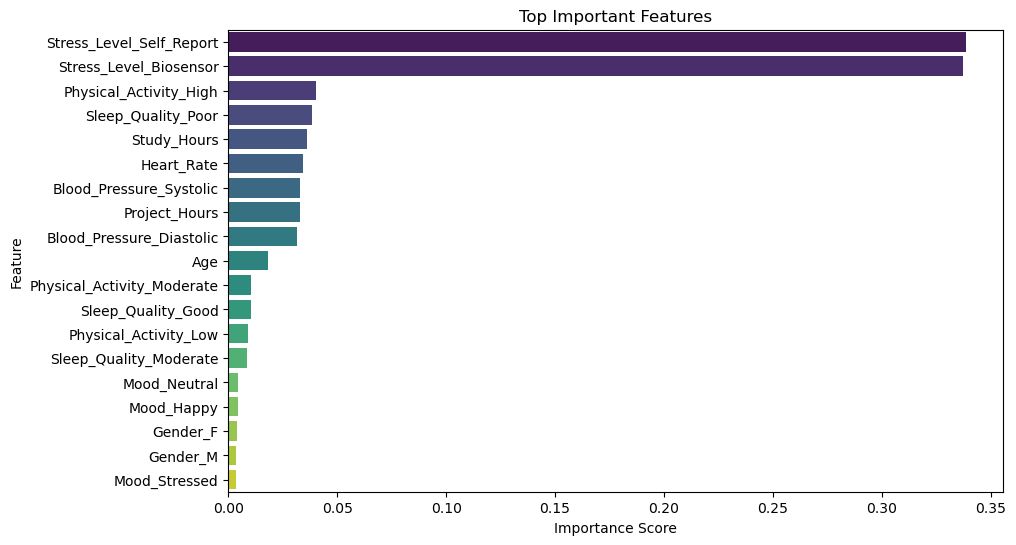

In [63]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_rf_tune[:20], hue='Feature', palette="viridis", legend=False)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Top Important Features')
plt.show()

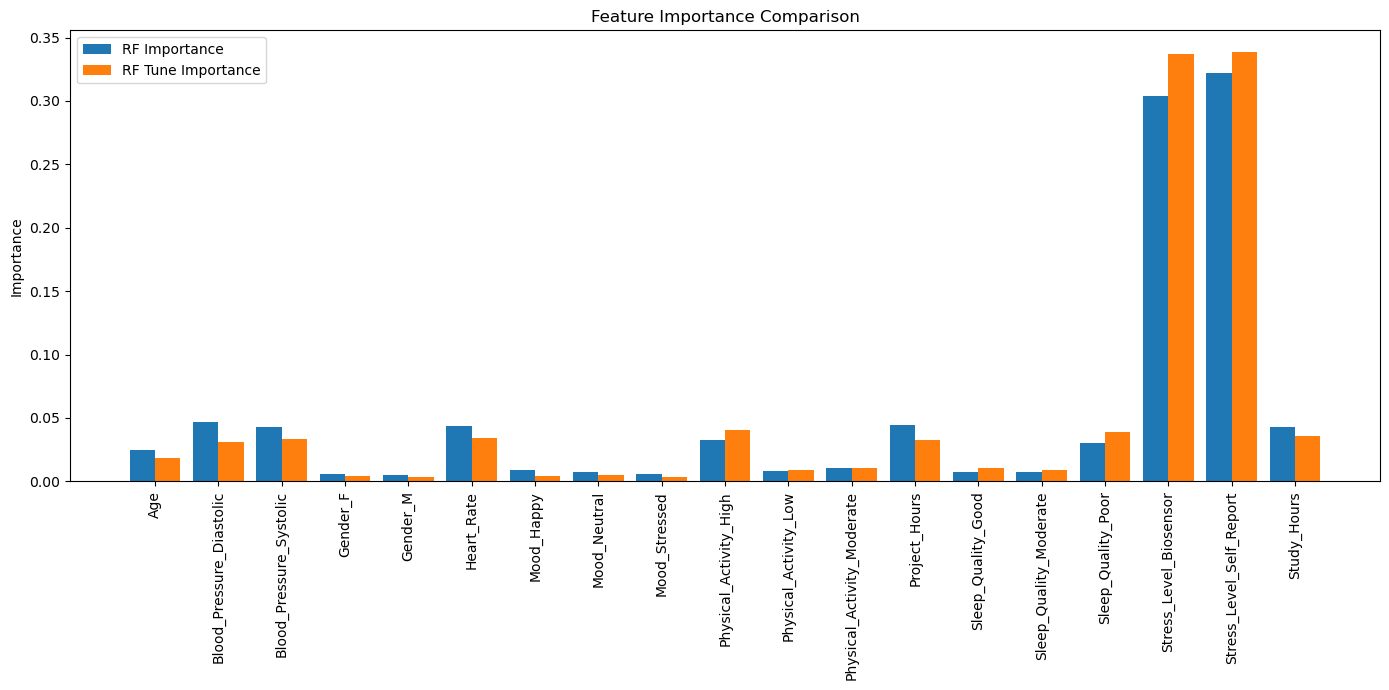

In [64]:
#ensure feature columns are same in both importance dataframes 
importance_rf = importance_rf.sort_values(by='Feature').reset_index(drop=True)
importance_rf_tune = importance_rf_tune.sort_values(by='Feature').reset_index(drop=True)

#merge dataframes on feature column
df_compare = pd.merge(importance_rf, importance_rf_tune, on='Feature', suffixes=('_rf', '_rf_tune'))

#plot comparison
fig, ax = plt.subplots(figsize=(14, 7))
width = 0.4  #width of the bars

#plot importance for initial model
ax.bar(df_compare.index - width / 2, df_compare['Importance_rf'], width, label='RF Importance')

#plot importance for tuned model
ax.bar(df_compare.index + width / 2, df_compare['Importance_rf_tune'], width, label='RF Tune Importance')

#set labels
ax.set_xticks(df_compare.index)
ax.set_xticklabels(df_compare['Feature'], rotation=90)
ax.set_ylabel('Importance')
ax.set_title('Feature Importance Comparison')
ax.legend()

#show plot
plt.tight_layout()
plt.show()

Only a slight change in feature importance in the tuned random forest compared to the initial random forest.
- Stress is still higlighted as the most important feature.
- Blood pressure, heart rate, high physical activity, poor sleep quality, and study/project hours are still significant.
    - Notice that stress, high physical activity, and poor sleep increased in importance in our tuned model.
    - We can see this in a couple of other features, but their overall importance is negligible

#### Tuned RF Final Test

Last part os the check how this model does with unseen data.

In [65]:
#make predictions on test set
y_pred = rf_tune.predict(X_test2)

#evaluate model
v_acc = accuracy_score(y_test2, y_pred)
v_f1 = f1_score(y_test2, y_pred, average='weighted')
v_precision = precision_score(y_test2, y_pred, average='weighted')
v_recall = recall_score(y_test2, y_pred, average='weighted')
confusion_crosstab = pd.crosstab(y_test2, y_pred, rownames=['Actual'], colnames=['Predicted'])

#print metrics
print(f'Random Forest (Tuned) Test Accuracy: {v_acc:.2f}')
print(f'Random Forest (Tuned) Weighted F1-Score: {v_f1:.2f}')
print(f'Random Forest (Tuned) Weighted Precision: {v_precision:.2f}')
print(f'Random Forest (Tuned) Weighted Recall: {v_recall:.2f}')
print('Confusion Matrix:')
print(confusion_crosstab)

Random Forest (Tuned) Test Accuracy: 1.00
Random Forest (Tuned) Weighted F1-Score: 1.00
Random Forest (Tuned) Weighted Precision: 1.00
Random Forest (Tuned) Weighted Recall: 1.00
Confusion Matrix:
Predicted   0   1   2
Actual               
0          18   0   0
1           0  66   0
2           0   0  14


As with the tuned decision tree, this model did great on unseen data.

## XGBoost

#### Initial XGB Model

In [66]:
#initialize xgboost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=13)

#train the model
xgb.fit(X_train2, y_train2)

#make predictions on validation set
y_pred = xgb.predict(X_val2)

#evaluate XGBoost
xgb_acc = accuracy_score(y_val2, y_pred)
xgb_f1 = f1_score(y_val2, y_pred, average='weighted')
xgb_precision = precision_score(y_val2, y_pred, average='weighted')
xgb_recall = recall_score(y_val2, y_pred, average='weighted')
confusion_crosstab = pd.crosstab(y_val2, y_pred, rownames = ['Actual'], colnames = ['Predicted'])

print(f'XGBoost Validation Accuracy: {xgb_acc:.2f}')
print(f'XGBoost Weighted F1-Score: {xgb_f1:.2f}')
print(f'XGBoost Weighted Precision: {xgb_precision:.2f}')
print(f'XGBoost Weighted Recall: {xgb_recall:.2f}')
print('Confusion Matrix:')
print(confusion_crosstab)

XGBoost Validation Accuracy: 1.00
XGBoost Weighted F1-Score: 1.00
XGBoost Weighted Precision: 1.00
XGBoost Weighted Recall: 1.00
Confusion Matrix:
Predicted   0   1   2
Actual               
0          19   0   0
1           0  65   0
2           0   0  14


In [67]:
#perform cross-validation
cv_scores = cross_val_score(xgb, X_train2, y_train2, cv=5, scoring='accuracy')
print(f'Cross-Validation Accuracy: {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})')

Cross-Validation Accuracy: 1.00 (+/- 0.01)


Right away, this model proves to be very successful in predicting health risk levels. Even the CV accusracy is quite high and the CV standard deviation is quite low.

#### XGBost Feature Importance

In [68]:
#get feature importanc scores
feature_importance = xgb.feature_importances_

#create dataframe to visualize feature importance scores
importance_xgb = pd.DataFrame({'Feature': X_train_encode.columns, 'Importance': feature_importance})

#sort by importance in descending order
importance_xgb = importance_xgb.sort_values(by='Importance', ascending=False)

#display top features
print(importance_xgb)

                       Feature  Importance
5     Stress_Level_Self_Report    0.401123
4       Stress_Level_Biosensor    0.319384
15          Sleep_Quality_Poor    0.141437
10      Physical_Activity_High    0.099521
6                  Study_Hours    0.012987
2      Blood_Pressure_Systolic    0.008283
12  Physical_Activity_Moderate    0.004191
1                   Heart_Rate    0.003148
13          Sleep_Quality_Good    0.002623
0                          Age    0.002099
7                Project_Hours    0.001914
14      Sleep_Quality_Moderate    0.001044
3     Blood_Pressure_Diastolic    0.000882
17                Mood_Neutral    0.000691
16                  Mood_Happy    0.000673
9                     Gender_M    0.000000
11       Physical_Activity_Low    0.000000
8                     Gender_F    0.000000
18               Mood_Stressed    0.000000


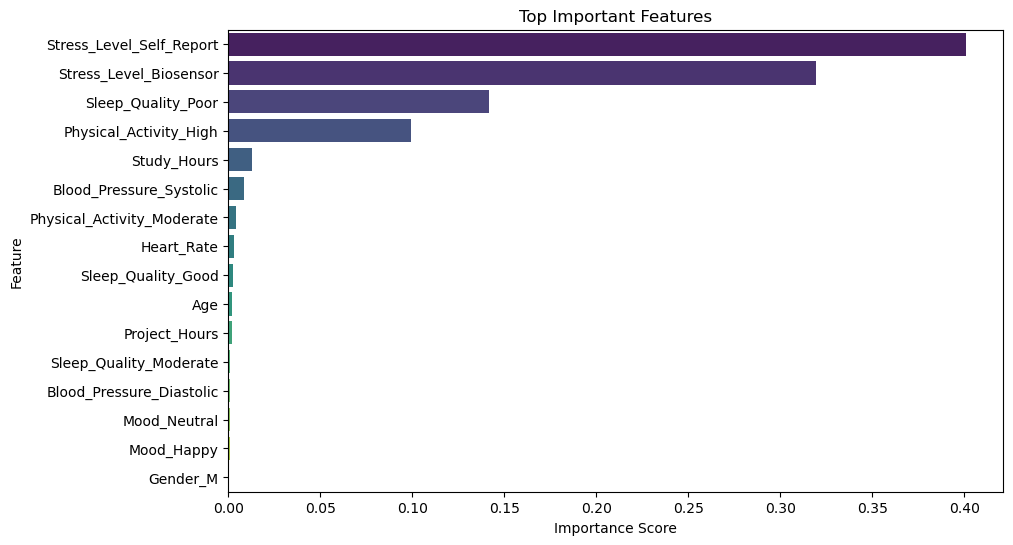

In [69]:
plt.figure(figsize=(10, 6))
sns.barplot(x=importance_xgb['Importance'][:16], y=importance_xgb['Feature'][:16], hue=importance_xgb['Feature'][:16], 
            palette="viridis", legend=False)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Top Important Features')
plt.show()

Feature importance follows similarly to that of our previous tree models.
- Stress retains the status as most important.
- Poor sleep quality and high physical activity are the next most important.
- All other features only hold 1% or less of importance each.

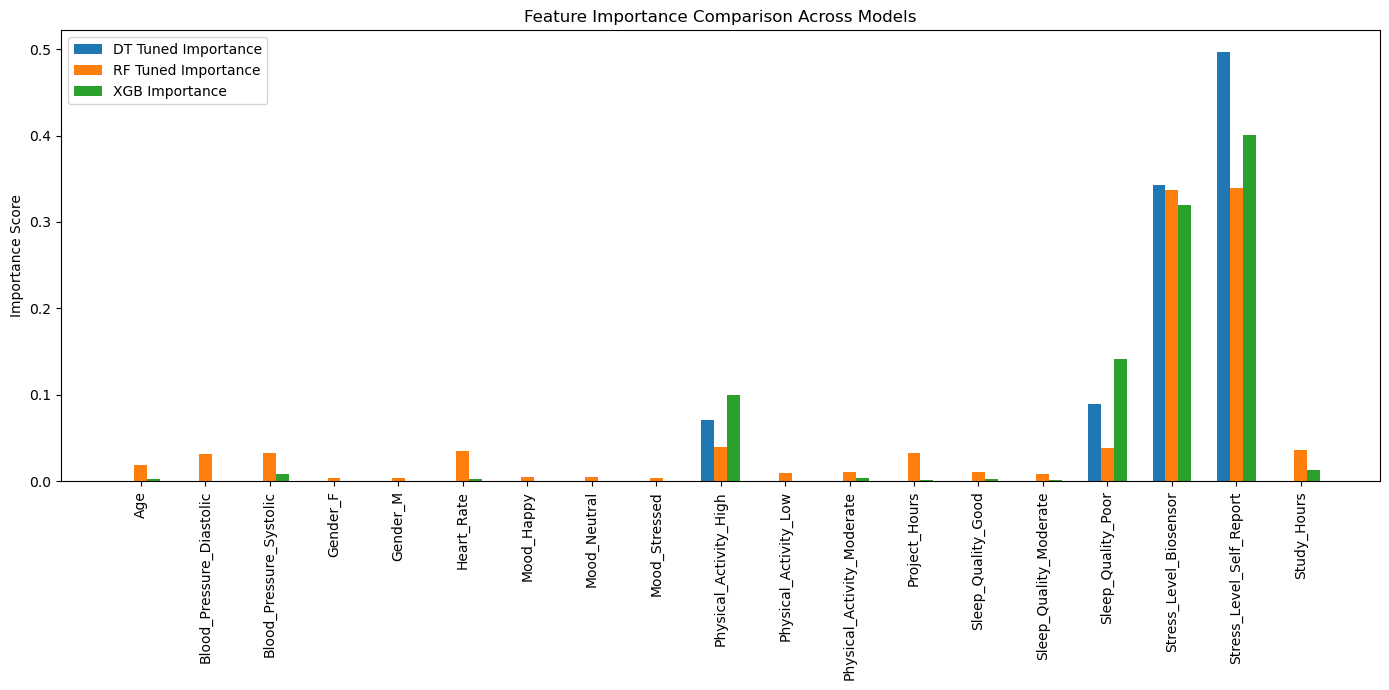

In [70]:
#ensure feature columns are the same
importance_dt_tune = importance_dt_tune.sort_values(by='Feature').reset_index(drop=True)
importance_rf_tune = importance_rf_tune.sort_values(by='Feature').reset_index(drop=True)
importance_xgb = importance_xgb.sort_values(by='Feature').reset_index(drop=True)

#merge on feature column
df_compare = importance_dt_tune.merge(importance_rf_tune, on='Feature', suffixes=('_dt_tune', '_rf_tune'))
df_compare = df_compare.merge(importance_xgb, on='Feature')
df_compare.rename(columns={'Importance': 'Importance_xgb'}, inplace=True)

#plot comparison
fig, ax = plt.subplots(figsize=(14, 7))
width = 0.2  #width of the bars

#plot importance for Tuned Decision Tree
ax.bar(df_compare.index - width, df_compare['Importance_dt_tune'], width, label='DT Tuned Importance')

#plot importance for Tuned Random Forest
ax.bar(df_compare.index, df_compare['Importance_rf_tune'], width, label='RF Tuned Importance')

# plot importance for XGBoost
ax.bar(df_compare.index + width, df_compare['Importance_xgb'], width, label='XGB Importance')

#set labels
ax.set_xticks(df_compare.index)
ax.set_xticklabels(df_compare['Feature'], rotation=90)
ax.set_ylabel('Importance Score')
ax.set_title('Feature Importance Comparison Across Models')
ax.legend()

#show plot
plt.tight_layout()
plt.show()

Here, we can see the feature importance from the tunned decisiont tree, the tuned random forest, and the xgb model.
- All three models indicate that the most important features are stress levels, poor sleep quality, and high physical activity.
- Other notable features are study/project hours, heart rate, and blood pressure.
- Age is also something to consider, but all other features are seemingly unimportant.

#### XGBoost Final Test

In [71]:
#make predictions on validation set
y_pred = xgb.predict(X_test2)

#evaluate XGBoost
xgb_acc = accuracy_score(y_test2, y_pred)
xgb_f1 = f1_score(y_test2, y_pred, average='weighted')
xgb_precision = precision_score(y_test2, y_pred, average='weighted')
xgb_recall = recall_score(y_test2, y_pred, average='weighted')
confusion_crosstab = pd.crosstab(y_test2, y_pred, rownames = ['Actual'], colnames = ['Predicted'])

print(f'XGBoost Validation Accuracy: {xgb_acc:.2f}')
print(f'XGBoost Weighted F1-Score: {xgb_f1:.2f}')
print(f'XGBoost Weighted Precision: {xgb_precision:.2f}')
print(f'XGBoost Weighted Recall: {xgb_recall:.2f}')
print('Confusion Matrix:')
print(confusion_crosstab)

XGBoost Validation Accuracy: 1.00
XGBoost Weighted F1-Score: 1.00
XGBoost Weighted Precision: 1.00
XGBoost Weighted Recall: 1.00
Confusion Matrix:
Predicted   0   1   2
Actual               
0          18   0   0
1           0  66   0
2           0   0  14


As expected, the xgb model performed excellently on unseen data.

# Further Tree-Based Modeling Exploration

Throughout this process, feature importance has been checked regularly. In each of the models, the same four features have shown to be the most important:
- Stress_Level_Self_Report, Stress_Level_Biosensor, Sleep_Quality_Poor, and Physical_Activity_High.

Other features have also shown some level of importance depending on the model.
- Decision Tree only gave the above four importance.
- Random Forest additionally gave blood pressure, heart rate, and study/project hours. Age also got some importance, but below 2%. Other features got minimal importance.
- The xgb model also gave additional importance to other features, but these came in at 1% or less.

To further investigate feature importance and how it impacts the tree-based models, A sub-dataset will be used containing only the four most relevant features. Aside from decreasing the number of features, everything else will be ran the same. In all likelyhood, this is expected to have minimal impact on the previous scores, if any.

***Note***: the data has been preprocessed already. All that needs to be done is to select the important features.

## Creating the subset

In [72]:
#define important features
important_features = ['Stress_Level_Self_Report', 'Stress_Level_Biosensor', 'Sleep_Quality_Poor', 'Physical_Activity_High']

#create subsets from encoded feature matrices
X_train_subset = X_train_encode[important_features]
X_val_subset = X_val_encode[important_features]
X_test_subset = X_test_encode[important_features]

#scale subsets
scaler = StandardScaler()
X_train_subset_scaled = scaler.fit_transform(X_train_subset)
X_val_subset_scaled = scaler.transform(X_val_subset)
X_test_subset_scaled = scaler.transform(X_test_subset)

#check the shapes
print(X_train_subset_scaled.shape, X_val_subset_scaled.shape, X_test_subset_scaled.shape)

#rename for ease of use
X_train3 = X_train_subset_scaled
X_val3 = X_val_subset_scaled
X_test3 = X_test_subset_scaled

(783, 4) (98, 4) (98, 4)


Now that we have our subsets, let's go through our models.

## Decision Tree

### Initial DT

In [73]:
#initialize decision tree
dt = DecisionTreeClassifier(random_state = 13)

#train the model
dt.fit(X_train3, y_train2)

#make predictions on validation set
y_pred = dt.predict(X_val3)

#evaluate model
v_acc = accuracy_score(y_val2, y_pred)
v_f1 = f1_score(y_val2, y_pred, average='weighted')
v_precision = precision_score(y_val2, y_pred, average='weighted')
v_recall = recall_score(y_val2, y_pred, average='weighted')
confusion_crosstab = pd.crosstab(y_val2, y_pred, rownames=['Actual'], colnames=['Predicted'])

print(f'Decision Tree Validation Accuracy: {v_acc:.2f}')
print(f'Decision Tree Weighted F1-Score: {v_f1:.2f}')
print(f'Decision Tree Weighted Precision: {v_precision:.2f}')
print(f'Decision Tree Weighted Recall: {v_recall:.2f}')
print('Confusion Matrix:')
print(confusion_crosstab)

#perform cross-validation
cv_scores = cross_val_score(dt, X_train3, y_train2, cv=5, scoring='accuracy')
print(f'Cross-Validation Accuracy: {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})')

Decision Tree Validation Accuracy: 0.97
Decision Tree Weighted F1-Score: 0.97
Decision Tree Weighted Precision: 0.97
Decision Tree Weighted Recall: 0.97
Confusion Matrix:
Predicted   0   1   2
Actual               
0          19   0   0
1           0  64   1
2           0   2  12
Cross-Validation Accuracy: 0.99 (+/- 0.01)


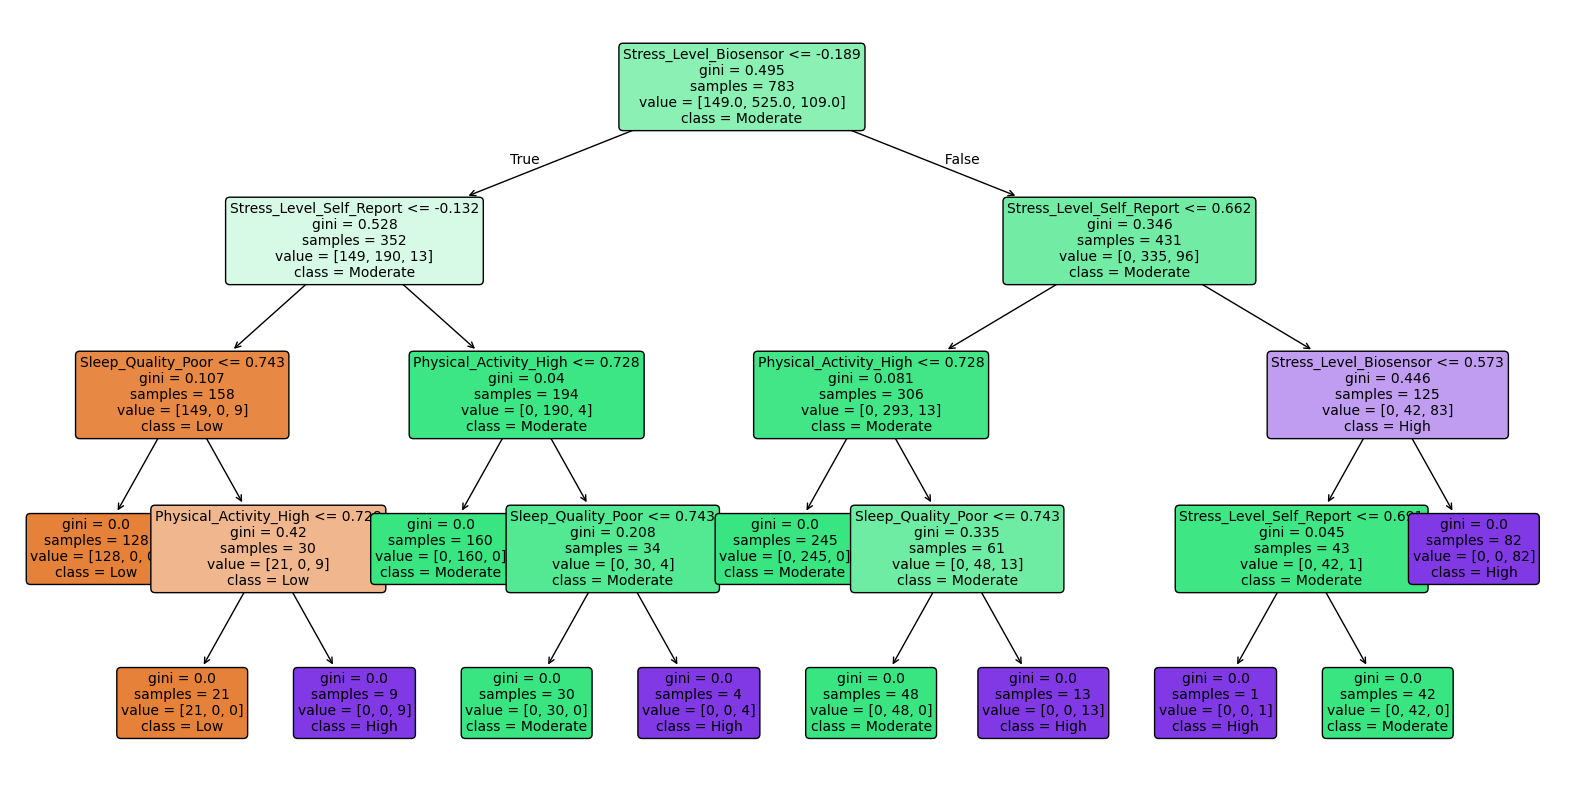

In [74]:
#set figure size
plt.figure(figsize=(20, 10))

#plot the decision tree
plot_tree(dt, 
          feature_names=X_train_subset.columns,  #make sure you pass the correct feature names
          class_names=label_encoder.classes_,    #class names from LabelEncoder
          filled=True, rounded=True, fontsize=10)
#show plot
plt.show()

In [75]:
print("Depth of the decision tree: ", dt.tree_.max_depth)#depth of tree
print("Number of nodes: ", dt.tree_.node_count) #number of nodes
print("Number of splits: ", dt.tree_.n_leaves) #number of splits

Depth of the decision tree:  4
Number of nodes:  23
Number of splits:  12


In [76]:
#get feature importanc scores
feature_importance = dt.feature_importances_

#create dataframe to visualize feature importance scores
importance_dt = pd.DataFrame({'Feature': X_train_subset.columns, 'Importance': feature_importance})

#sort by importance in descending order
importance_dt = importance_dt.sort_values(by='Importance', ascending=False)

#display top features
importance_dt

Feature  Importance
0  Stress_Level_Self_Report    0.597734
1    Stress_Level_Biosensor    0.273982
2        Sleep_Quality_Poor    0.082312
3    Physical_Activity_High    0.045973

Notes:
- The initial metrics, including the CV scores are the same as before.
- The tree is the same from the tuned decision tree we did above.
- These results are expected since all other features had 0% importance.

### Tune DT

In [77]:
#define parameter grid
params = {
    'max_depth': [2, 3, 4, 5, 6], #max depth of tree
    'min_samples_split': [2, 5, 10, 20], #values to control the number of splits
    'min_samples_leaf': [1, 5, 10, 20], #values to control minimum samples oer leaf node
    'criterion': ['gini', 'entropy'] #different splitting criteria
}

#initialize decision tree
dt = DecisionTreeClassifier(random_state = 13)

#initialize grid search
grid_search = GridSearchCV(estimator = dt, param_grid = params, cv = 10, scoring = 'f1_weighted')

In [78]:
grid_search.fit(X_train3, y_train2)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=13),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5, 6],
                         'min_samples_leaf': [1, 5, 10, 20],
                         'min_samples_split': [2, 5, 10, 20]},
             scoring='f1_weighted')

In [79]:
#get best parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

Best Parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [80]:
#define tuned model
dt_tune = grid_search.best_estimator_

#train the model
dt_tune.fit(X_train3, y_train2)

#make predictions on validation set
y_pred = dt_tune.predict(X_val3)

#evaluate model
v_acc = accuracy_score(y_val2, y_pred)
v_f1 = f1_score(y_val2, y_pred, average='weighted')
v_precision = precision_score(y_val2, y_pred, average='weighted')
v_recall = recall_score(y_val2, y_pred, average='weighted')
confusion_crosstab = pd.crosstab(y_val2, y_pred, rownames=['Actual'], colnames=['Predicted'])

print(f'Decision Tree (Tuned) Validation Accuracy: {v_acc:.2f}')
print(f'Decision Tree (Tuned) Weighted F1-Score: {v_f1:.2f}')
print(f'Decision Tree (Tuned) Weighted Precision: {v_precision:.2f}')
print(f'Decision Tree (Tuned) Weighted Recall: {v_recall:.2f}')
print('Confusion Matrix:')
print(confusion_crosstab)

#perform cross-validation
cv_scores = cross_val_score(dt_tune, X_train3, y_train2, cv=5, scoring='accuracy')
print(f'Cross-Validation Accuracy: {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})')

Decision Tree (Tuned) Validation Accuracy: 0.97
Decision Tree (Tuned) Weighted F1-Score: 0.97
Decision Tree (Tuned) Weighted Precision: 0.97
Decision Tree (Tuned) Weighted Recall: 0.97
Confusion Matrix:
Predicted   0   1   2
Actual               
0          19   0   0
1           0  64   1
2           0   2  12
Cross-Validation Accuracy: 1.00 (+/- 0.01)


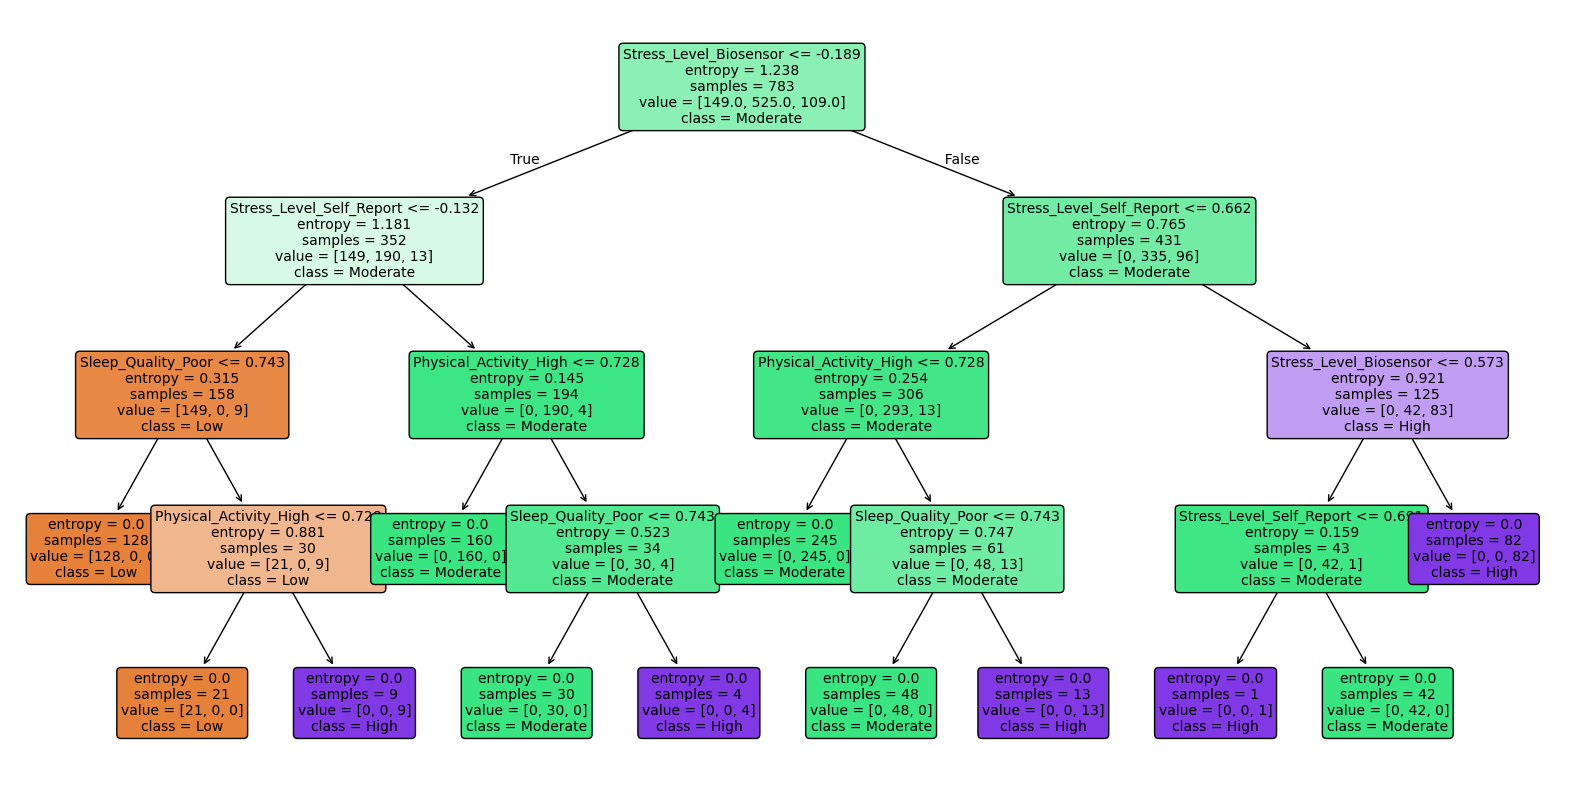

In [81]:
#set figure size
plt.figure(figsize=(20, 10))

#plot the decision tree
plot_tree(dt_tune, 
          feature_names=X_train_subset.columns,  #make sure you pass the correct feature names
          class_names=label_encoder.classes_,    #class names from LabelEncoder
          filled=True, rounded=True, fontsize=10)
#show plot
plt.show()

In [82]:
#get feature importanc scores
feature_importance = dt_tune.feature_importances_

#create dataframe to visualize feature importance scores
importance_dt_tune = pd.DataFrame({'Feature': X_train_subset.columns, 'Importance': feature_importance})

#sort by importance in descending order
importance_dt_tune = importance_dt_tune.sort_values(by='Importance', ascending=False)

#display top features
importance_dt_tune

Feature  Importance
0  Stress_Level_Self_Report    0.496835
1    Stress_Level_Biosensor    0.342758
2        Sleep_Quality_Poor    0.089460
3    Physical_Activity_High    0.070946

In [83]:
#final test

#make predictions on test set
y_pred = dt_tune.predict(X_test3)

#evaluate model
v_acc = accuracy_score(y_test2, y_pred)
v_f1 = f1_score(y_test2, y_pred, average='weighted')
v_precision = precision_score(y_test2, y_pred, average='weighted')
v_recall = recall_score(y_test2, y_pred, average='weighted')
confusion_crosstab = pd.crosstab(y_test2, y_pred, rownames=['Actual'], colnames=['Predicted'])

print(f'Decision Tree (Tuned) Test Accuracy: {v_acc:.2f}')
print(f'Decision Tree (Tuned) Weighted F1-Score: {v_f1:.2f}')
print(f'Decision Tree (Tuned) Weighted Precision: {v_precision:.2f}')
print(f'Decision Tree (Tuned) Weighted Recall: {v_recall:.2f}')
print('Confusion Matrix:')
print(confusion_crosstab)

Decision Tree (Tuned) Test Accuracy: 1.00
Decision Tree (Tuned) Weighted F1-Score: 1.00
Decision Tree (Tuned) Weighted Precision: 1.00
Decision Tree (Tuned) Weighted Recall: 1.00
Confusion Matrix:
Predicted   0   1   2
Actual               
0          18   0   0
1           0  66   0
2           0   0  14


Notes:
- Again, we don't see much dofference. Since all other features had 0% importance, cutting them out for the deicsion tree would only make the tree less complicated, not have any strong adjustment to the performance.

## Random Forest

### Initial RF

In [84]:
#initialize random forest
rf = RandomForestClassifier(random_state=13)

#train the model
rf.fit(X_train3, y_train2)

#make predictions on validation set
y_pred = rf.predict(X_val3)

#evaluate random forest
rf_acc = accuracy_score(y_val2, y_pred)
rf_f1 = f1_score(y_val2, y_pred, average='weighted')
rf_precision = precision_score(y_val2, y_pred, average='weighted')
rf_recall = recall_score(y_val2, y_pred, average='weighted')
confusion_crosstab = pd.crosstab(y_val2, y_pred, rownames = ['Actual'], colnames = ['Predicted'])

#print metrics
print(f'Random Forest Validation Accuracy: {rf_acc:.2f}')
print(f'Random Forest Weighted F1-Score: {rf_f1:.2f}')
print(f'Random Forest Weighted Precision: {rf_precision:.2f}')
print(f'Random Forest Weighted Recall: {rf_recall:.2f}')
print('Confusion Matrix:')
print(confusion_crosstab)

#perform cross-validation
cv_scores = cross_val_score(rf, X_train3, y_train2, cv=5, scoring='accuracy')
print(f'Cross-Validation Accuracy: {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})')

Random Forest Validation Accuracy: 0.98
Random Forest Weighted F1-Score: 0.98
Random Forest Weighted Precision: 0.98
Random Forest Weighted Recall: 0.98
Confusion Matrix:
Predicted   0   1   2
Actual               
0          19   0   0
1           0  65   0
2           0   2  12
Cross-Validation Accuracy: 1.00 (+/- 0.01)


In [85]:
#get feature importanc scores
feature_importance = rf.feature_importances_

#create dataframe to visualize feature importance scores
importance_rf = pd.DataFrame({'Feature': X_train_subset.columns, 'Importance': feature_importance})

#sort by importance in descending order
importance_rf = importance_rf.sort_values(by='Importance', ascending=False)

#display top features
importance_rf

Feature  Importance
0  Stress_Level_Self_Report    0.450132
1    Stress_Level_Biosensor    0.442782
2        Sleep_Quality_Poor    0.056904
3    Physical_Activity_High    0.050182

Notes:
- The only notable difference is that the average CV accuracy is higher and the standard deviation is lower. This indicates that the model consistently performs well and is stable across all folds. Thus, the model should generalize well.

### Tune RF

In [86]:
#define parameter grid
params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

#initialize random forest
rf = RandomForestClassifier(random_state = 56)

#initialize grid search
grid_search = GridSearchCV(estimator = rf, param_grid = params, cv=10, n_jobs=-1, verbose=2, scoring = 'f1_weighted')

In [87]:
#fit the grid search
grid_search.fit(X_train3, y_train2)

Fitting 10 folds for each of 432 candidates, totalling 4320 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=56),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 20],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 150, 200]},
             scoring='f1_weighted', verbose=2)

In [88]:
#get best parameters
best_params = grid_search.best_params_
print(f'Best Parameters: {best_params}')

Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [89]:
#get best model from grid search
rf_tune = grid_search.best_estimator_

#train the tuned model
rf_tune.fit(X_train3, y_train2)

#make predictions
y_pred = rf_tune.predict(X_val3)

#evaluate model 
v_acc = accuracy_score(y_val2, y_pred)
v_f1 = f1_score(y_val2, y_pred, average='weighted')
v_precision = precision_score(y_val2, y_pred, average='weighted')
v_recall = recall_score(y_val2, y_pred, average='weighted')
confusion_crosstab = pd.crosstab(y_val2, y_pred, rownames=['Actual'], colnames=['Predicted'])

#print metrics
print(f'Random Forest (Tuned) Validation Accuracy: {v_acc:.2f}')
print(f'Random Forest (Tuned) Weighted F1-Score: {v_f1:.2f}')
print(f'Random Forest (Tuned) Weighted Precision: {v_precision:.2f}')
print(f'Random Forest (Tuned) Weighted Recall: {v_recall:.2f}')
print('Confusion Matrix:')
print(confusion_crosstab)

#perform cross-validation
cv_scores = cross_val_score(rf_tune, X_train3, y_train2, cv=5, scoring='accuracy')
print(f'Cross-Validation Accuracy: {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})')

Random Forest (Tuned) Validation Accuracy: 0.99
Random Forest (Tuned) Weighted F1-Score: 0.99
Random Forest (Tuned) Weighted Precision: 0.99
Random Forest (Tuned) Weighted Recall: 0.99
Confusion Matrix:
Predicted   0   1   2
Actual               
0          19   0   0
1           0  65   0
2           0   1  13
Cross-Validation Accuracy: 1.00 (+/- 0.01)


In [90]:
#get feature importance scores
feature_importance = rf_tune.feature_importances_

#create dataframe to visualize feature importance scores
importance_rf_tune = pd.DataFrame({'Feature': X_train_subset.columns, 'Importance': feature_importance})

#sort by importance in descending order
importance_rf_tune = importance_rf_tune.sort_values(by='Importance', ascending=False)

#display top features
importance_rf_tune

Feature  Importance
0  Stress_Level_Self_Report    0.443946
1    Stress_Level_Biosensor    0.425898
2        Sleep_Quality_Poor    0.069474
3    Physical_Activity_High    0.060683

In [91]:
#make predictions on test set
y_pred = rf_tune.predict(X_test3)

#evaluate model
v_acc = accuracy_score(y_test2, y_pred)
v_f1 = f1_score(y_test2, y_pred, average='weighted')
v_precision = precision_score(y_test2, y_pred, average='weighted')
v_recall = recall_score(y_test2, y_pred, average='weighted')
confusion_crosstab = pd.crosstab(y_test2, y_pred, rownames=['Actual'], colnames=['Predicted'])

#print metrics
print(f'Random Forest (Tuned) Test Accuracy: {v_acc:.2f}')
print(f'Random Forest (Tuned) Weighted F1-Score: {v_f1:.2f}')
print(f'Random Forest (Tuned) Weighted Precision: {v_precision:.2f}')
print(f'Random Forest (Tuned) Weighted Recall: {v_recall:.2f}')
print('Confusion Matrix:')
print(confusion_crosstab)

Random Forest (Tuned) Test Accuracy: 1.00
Random Forest (Tuned) Weighted F1-Score: 1.00
Random Forest (Tuned) Weighted Precision: 1.00
Random Forest (Tuned) Weighted Recall: 1.00
Confusion Matrix:
Predicted   0   1   2
Actual               
0          18   0   0
1           0  66   0
2           0   0  14


Notes:
- Grid search took a lot less time, likely due to the smaller dataset.
- The evaluation metrics are the same.
- The CV scores here are slightly better than the original tuned random forest. The accuracy is higher and the standard deviation is lower.
- No change in the final test performance.

## XGBoost

In [92]:
#initialize xgboost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=13)

#train the model
xgb.fit(X_train3, y_train2)

#make predictions on validation set
y_pred = xgb.predict(X_val3)

#evaluate XGBoost
xgb_acc = accuracy_score(y_val2, y_pred)
xgb_f1 = f1_score(y_val2, y_pred, average='weighted')
xgb_precision = precision_score(y_val2, y_pred, average='weighted')
xgb_recall = recall_score(y_val2, y_pred, average='weighted')
confusion_crosstab = pd.crosstab(y_val2, y_pred, rownames = ['Actual'], colnames = ['Predicted'])

print(f'XGBoost Validation Accuracy: {xgb_acc:.2f}')
print(f'XGBoost Weighted F1-Score: {xgb_f1:.2f}')
print(f'XGBoost Weighted Precision: {xgb_precision:.2f}')
print(f'XGBoost Weighted Recall: {xgb_recall:.2f}')
print('Confusion Matrix:')
print(confusion_crosstab)

#perform cross-validation
cv_scores = cross_val_score(xgb, X_train3, y_train2, cv=5, scoring='accuracy')
print(f'Cross-Validation Accuracy: {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})')

XGBoost Validation Accuracy: 1.00
XGBoost Weighted F1-Score: 1.00
XGBoost Weighted Precision: 1.00
XGBoost Weighted Recall: 1.00
Confusion Matrix:
Predicted   0   1   2
Actual               
0          19   0   0
1           0  65   0
2           0   0  14
Cross-Validation Accuracy: 1.00 (+/- 0.01)


In [93]:
#get feature importanc scores
feature_importance = xgb.feature_importances_

#create dataframe to visualize feature importance scores
importance_xgb = pd.DataFrame({'Feature': X_train_subset.columns, 'Importance': feature_importance})

#sort by importance in descending order
importance_xgb = importance_xgb.sort_values(by='Importance', ascending=False)

#display top features
importance_xgb

Feature  Importance
0  Stress_Level_Self_Report    0.393750
1    Stress_Level_Biosensor    0.316934
2        Sleep_Quality_Poor    0.168043
3    Physical_Activity_High    0.121274

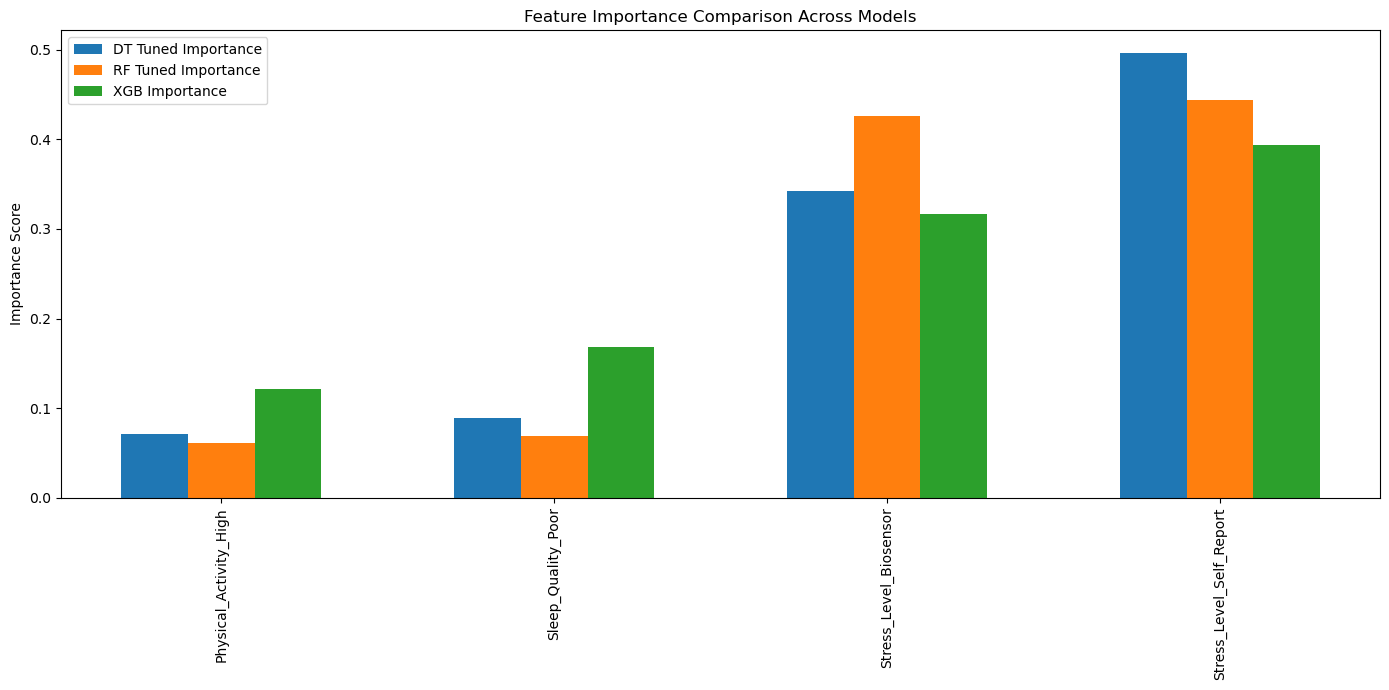

In [94]:
#ensure feature columns are the same
importance_dt_tune = importance_dt_tune.sort_values(by='Feature').reset_index(drop=True)
importance_rf_tune = importance_rf_tune.sort_values(by='Feature').reset_index(drop=True)
importance_xgb = importance_xgb.sort_values(by='Feature').reset_index(drop=True)

#merge on feature column
df_compare = importance_dt_tune.merge(importance_rf_tune, on='Feature', suffixes=('_dt_tune', '_rf_tune'))
df_compare = df_compare.merge(importance_xgb, on='Feature')
df_compare.rename(columns={'Importance': 'Importance_xgb'}, inplace=True)

#plot comparison
fig, ax = plt.subplots(figsize=(14, 7))
width = 0.2  #width of the bars

#plot importance for Tuned Decision Tree
ax.bar(df_compare.index - width, df_compare['Importance_dt_tune'], width, label='DT Tuned Importance')

#plot importance for Tuned Random Forest
ax.bar(df_compare.index, df_compare['Importance_rf_tune'], width, label='RF Tuned Importance')

# plot importance for XGBoost
ax.bar(df_compare.index + width, df_compare['Importance_xgb'], width, label='XGB Importance')

#set labels
ax.set_xticks(df_compare.index)
ax.set_xticklabels(df_compare['Feature'], rotation=90)
ax.set_ylabel('Importance Score')
ax.set_title('Feature Importance Comparison Across Models')
ax.legend()

#show plot
plt.tight_layout()
plt.show()

In [95]:
#make predictions on validation set
y_pred = xgb.predict(X_test3)

#evaluate XGBoost
xgb_acc = accuracy_score(y_test2, y_pred)
xgb_f1 = f1_score(y_test2, y_pred, average='weighted')
xgb_precision = precision_score(y_test2, y_pred, average='weighted')
xgb_recall = recall_score(y_test2, y_pred, average='weighted')
confusion_crosstab = pd.crosstab(y_test2, y_pred, rownames = ['Actual'], colnames = ['Predicted'])

print(f'XGBoost Validation Accuracy: {xgb_acc:.2f}')
print(f'XGBoost Weighted F1-Score: {xgb_f1:.2f}')
print(f'XGBoost Weighted Precision: {xgb_precision:.2f}')
print(f'XGBoost Weighted Recall: {xgb_recall:.2f}')
print('Confusion Matrix:')
print(confusion_crosstab)

XGBoost Validation Accuracy: 1.00
XGBoost Weighted F1-Score: 1.00
XGBoost Weighted Precision: 1.00
XGBoost Weighted Recall: 1.00
Confusion Matrix:
Predicted   0   1   2
Actual               
0          18   0   0
1           0  66   0
2           0   0  14


Notes:
- No changes in evaluation metrics.

# Conclusions

## Exploratory Data Analysis

**Initial Look and Data Preparation**

The initial assessment of the dataset revealed that it was well-structured, with no missing values or duplicates. This provided a strong foundation for further analysis. The object data types were converted to categorical variables, while the numerical data types were already appropriate. This preprocessing step ensured that the data was in a suitable format for subsequent analysis.

**Outlier Analysis**

The summary statistics of the numerical data revealed that some features were on different scales, which will need to be addressed during model preparation. Notably, there were significant jumps from the 75th percentile to the maximum value in features such as heart rate, blood pressure, and study/project hours, indicating potential outliers. The average and median heart rate and blood pressure values aligned with established norms, suggesting that the data accurately reflects the general population. However, the maximum values in these features suggested potentially serious health issues.
- https://www.heart.org/en/health-topics/high-blood-pressure/understanding-blood-pressure-readings
- https://www.heart.org/en/health-topics/high-blood-pressure/the-facts-about-high-blood-pressure/all-about-heart-rate-pulse

The histograms of numerical variables indicated a relatively uniform age distribution, implying a consistent number of students across different ages. Heart rate, blood pressure, and study/project hours followed a normal distribution, while stress levels appeared uniformly distributed. Boxplots verified the presence of outliers in Heart_Rate, Blood_Pressure_Systolic, Blood_Pressure_Diastolic, Study_Hours, and Project_Hours, with Heart_Rate and Project_Hours exhibiting the most outliers. Age and stress levels did not show any outliers, reinforcing their uniform distribution.

A detailed analysis using the interquartile range (IQR) method identified 21 outliers across several features. Heart rate had five outliers, though they remained within the higher end of the normal range (60-100 bpm), likely influenced by factors such as stress, physical activity, and sleep quality. Both blood pressure each had one high outlier, raising potential concerns about hypertension. Study hours showed three outliers, representing students who studied significantly longer than their peers, which could negatively impact their well-being. Project hours had the most outliers, with 11 instances, suggesting that excessive project workloads might be linked to increased health risks. After removing these 21 outliers, the dataset was refined to 979 instances for further analysis.

**Numerical Correlation Analysis**

Both Pearson and Spearman correlation analyses revealed no significant correlations among numerical features. Scatterplots were used to visualize correlations, simplifying the analysis by showing no need to account for interdependencies between variables. This approach could help predictive models uncover unique insights and better recognize different patterns. Algorithms such as Random Forest and Gradient Boosting can help identify the importance of each feature without the issue of multicollinearity.

Boxplots comparing numerical features with the target variable revealed several key insights. Individuals in the high-risk category tended to have a higher median age compared to those in the moderate- and low-risk groups, while the low-risk group exhibited a wider age range, indicating more variability. Heart rate, Blood pressure, and study/project hours had realtively stable median values across all risk levels, with minimal variability, suggesting these factors may not strongly differentiate health risk categories. However, the stress features showed significant variation across risk levels, indicating a potential relationship between higher stress and increased health risk.

**Categorical Feature Analysis**

The category distribution analysis, visualized through a distribution table and pie charts, revealed a balanced gender distribution, ensuring unbiased gender-based analyses. Most students engaged in moderate physical activity, while fewer participated in high or low activity levels. Sleep quality varied, with many students reporting good sleep, but a significant portion experiencing moderate or poor sleep, potentially impacting their well-being and academic performance. Mood distribution showed that the majority of students felt happy or neutral, whereas a smaller group reported feeling stressed, emphasizing the need for better mental health support. Regarding health risk levels, most students fell into the moderate-risk category, with fewer classified as low-risk and even fewer as high-risk. This highlights the need to focus health interventions on those at moderate and high risk.

Chi-Square tests and heatmaps revealed important relationships between categorical variables, uncovering several significant correlations. Gender was strongly associated with both physical activity and sleep quality, suggesting that tailored interventions could help address differences in lifestyle habits. Physical activity also showed a clear correlation with health risk levels, reinforcing the role of regular exercise in overall well-being. Similarly, sleep quality was closely linked to Health Risk Levels, emphasizing the correlation between rest and potential health risks. While heatmaps effectively visualized the frequency of occurrences between variable pairs and highlighted potential patterns, they did not provide statistical significance on their own.

## Data Preprocessing

To ensure a robust and reliable model, the dataset was carefully split into three distinct sets: 80% for training, 10% for validation and hyperparameter tuning, and 10% for final testing. To ensure consistency across all subsets, the distribution of target variable categories was maintained, preventing any imbalance that could skew model performance. This approach ensures that the model can generalize well with unseen data.

With the data split, preprocessing was the next step to prepare for modeling. The target variable was encoded using LabelEncoder, ensuring each category was represented as a unique integer For the other categorical variables, pd.get_dummies was used for one-hot encoding to preserve meaningful relationships without imposing an arbitrary order. A StandardScaler was applied to numerical features to normalize them, preventing models that rely on distance-based calculations from being influenced by differing scales.

An additional alignment step was performed to guarantee that all datasets (training, validation, and test) contained the same features. This prevents inconsistencies during model training and ensures that all models receive data in a uniform structure. Proper preprocessing is essential for achieving reliable, high-performing models, as it minimizes bias and allows each algorithm to extract meaningful insights effectively. By preparing the data systematically, we create a solid foundation for accurate and interpretable predictions across multiple modeling approaches.

## Tree Models

**Decision Tree**

The initial evaluation of the decision tree model showed a 97% overall accuracy, indicating strong performance in classifying instances correctly. With Weighted F1-Score, Precision, and Recall all at 97%, the model demonstrates a good balance across classes. The high F1-Score reflects a good balance between precision and recall. High precision means that the model's predictions are likely correct, while high recall suggests it captures most actual instances. Notably, there were no misclassifications for Low risk levels, showcasing the model's confidence and accuracy in predicting this class. However, two High risk levels were predicted as Moderate, and one Moderate instance was classified as High, indicating some difficulty distinguishing between these two classes.

The cross-validation score revealed a mean accuracy of 99% across different folds, suggesting the model generalizes well to unseen data and is not overfitting. The low standard deviation indicates stable and consistent performance across different folds, meaning the model's performance does not vary much with different subsets of the data.

An initial visual analysis of the decision tree highlighted that stress levels are the most important feature in predicting health risk levels. Poor sleep quality, blood pressure, and high physical activity were also significant features. Study hours and project hours played a role as well. The tree's low depth helps it capture data nuances without overfitting, with leaf nodes providing clear decision paths for different feature combinations.

Feature importance analysis showed that stress levels are the most significant. Poor sleep quality and high physical activity also hold some significance, while systolic blood pressure and project/study hours have minimal importance. Other features were deemed unimportant.

Tuning the tree did not result in any discernible differences in evaluation metrics. The tuned tree was less complex, but stress, poor sleep quality, and high physical activity remained important features. Blood_Pressure_Systolic, Study_Hours, and Project_Hours no longer held any significance, consistent with their minimal importance before tuning.

In the final test, the model performed exceptionally, achieving 100% on all metrics.

Insights from the Decision Tree analysis highlighted several key factors influencing student health. Stress reduction interventions could significantly improve overall health, while improving sleep quality for those with poor sleep could help lower health risk levels. Physical activity also emerged as an important factor impacting health risk, underscoring the need for promoting exercise. Additionally, the analysis revealed the risk of misclassifying high-risk cases as moderate, which could result in missed critical interventions. This suggests that a recall-focused approach, prioritizing the identification of high-risk individuals, might be more beneficial to ensure timely and accurate health interventions.

**Random Forest**

The Random Forest model showed slightly better metrics than the Decision Tree, which was already performing well. Only two instances were misclassified, with 2 High instances classified as Moderate. Overall, the performance metrics and confusion matrix indicate that the Random Forest model is performing very well, with minimal misclassifications. The interpretations of the metrics follow that from the Decision Tree. The cross-validation score mean accuracy is 97%, indicating consistent performance across different folds, though slightly lower than the Decision Tree. The standard deviation is low, suggesting stable and consistent performance across folds, although it is slightly higher than the Decision Tree.

The initial feature importance analysis showed a few similarities and differences compared to the Decision Tree model. Stress levels were again the most important feature, accounting for over 62% of the total feature importance. Blood pressure, heart rate, and study/project hours were also significant, contributing over 22% of the total importance. High physical activity, poor sleep quality, and age emerged as noticeable contributors to the model. However, the remaining features had minimal impact on the model’s predictions.

After hyperparameter tuning, the Random Forest model showed slight improvements across key metrics, with accuracy, weighted F1, precision, and recall all reaching 99%. Only one high-risk instance was misclassified as moderate, with no other errors. The mean cross-validation accuracy increased to 98%, and the standard deviation decreased to 0.02, signaling slightly better consistency and performance compared to the initial model.

There was only a slight change in feature importance in the tuned Random Forest compared to the initial model. Stress, high physical activity, and poor sleep quality increased in importance in the tuned model. Some other features also increased slightly in importance, but their overall significance remains negligible. Age, blood pressure, heart rate, and study/project hours decreased in importance.

The tuned model performed exceptionally well, achieving perfect evaluations.

The insights from the Random Forest analysis further reinforced several key factors influencing student health. Stress reduction interventions remain crucial, as they continue to have a significant potential impact on student health. Improving poor sleep quality was also highlighted as a key factor, with the ability to lower health risks. High physical activity consistently showed its importance in reducing health risks, while blood pressure and heart rate emerged as essential physiological indicators, likely linked to stress. Additionally, the analysis highlighted the role of academic load, with increased study and project hours potentially contributing to higher stress levels and, in turn, affecting health risk.

**XGBoost**

The evaluation of the XGBoost model showed perfect results, with 100% accuracy, F1-score, precision, and recall. The mean cross-validation accuracy score was also 100%, with a standard deviation of 0.01, indicating exceptional and consistent performance.

Feature importance in the XGBoost model closely followed previous models. Like the Random Forest, this model gave more importance to additional features, though these importance scores were incredibly small, each contributing 1% or less. All three models consistently indicate that the most important features are stress levels, poor sleep quality, and high physical activity. Other notable features include study/project hours, heart rate, and blood pressure. Age is also somewhat important, but all other features are seemingly unimportant.

The final test of the XGBoost model confirmed its perfect performance, further validating its effectiveness in predicting health risks.

The insights from the XGBoost model closely aligned with the findings from previous models.

**Subset**

It should be noted that a subset of the data was created based on the consistent feature importance scores. With this subset, each type of tree-based model was ran and retuned. No discernible difference was found.

## Insights and Further Investigations

**Insights**

Stress levels emerged as the most significant predictor of health risk across all models. This aligns with established research indicating that high stress is a known risk factor for various health issues. Interventions and techniques targeting stress reduction could significantly improve student health.

Poor sleep quality was consistently highlighted as an important factor impacting health risk levels. Improving sleep quality through initiatives like sleep hygiene education and stress management could help reduce health risks among students.

High physical activity was consistently shown to impact health risk levels. Encouraging regular physical activity and integrating it into students' routines can help improve their overall health and well-being.

These physiological metrics were important indicators of health risk and were likely correlated with stress. Monitoring and managing blood pressure and heart rate through regular check-ups and stress reduction techniques could help mitigate health risks.

Study and project hours were shown to play a role in health risk prediction. Higher academic load may contribute to increased stress levels, which in turn affects health. Balancing academic responsibilities with stress management strategies can help students maintain better health.

The models occasionally misclassified High risk instances as Moderate. This could be potentially dangerous if it leads to missed critical interventions. A recall-focused approach might be beneficial to ensure high-risk cases receive the necessary care.

Other features contributed very little to the model's predictions and were deemed unimportant. Focusing on the most significant predictors can streamline intervention strategies and resource allocation.

**Further Investigations and Research**

Conducting longitudinal studies to track changes in students' stress levels, sleep quality, physical activity, and health outcomes over time can provide deeper insights into the long-term effects of these factors on health.

Implementing and evaluating intervention programs aimed at reducing stress, improving sleep quality, and promoting physical activity can help determine the effectiveness of these strategies in improving student health.

Investigating the correlation between health risk factors and academic performance can provide valuable insights into how health impacts students' educational outcomes and vice versa.

Exploring the impact of mental health support services on students' stress levels and overall health can highlight the importance of accessible mental health resources on campus.

Developing and assessing holistic health programs that address multiple risk factors simultaneously (e.g., stress management, sleep quality, physical activity, and nutrition) can provide a comprehensive approach to improving student health.

Investigating the potential for personalized interventions based on individual risk profiles can help tailor strategies to meet the unique needs of each student.

By focusing on these areas, we can gain a more comprehensive understanding of the factors influencing student health and develop targeted interventions to promote well-being.